In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import os
import pathlib
import pandas as pd
import numpy as np
import re
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.quant.quant_lfq_ion_DDA_QExactive import DDAQuantIonModuleQExactive
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.i2masschroq import extract_params as extract_i2masschroq_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.sage import extract_params as extract_sage_params
from proteobench.io.params.alphapept import extract_params as extract_alphapept_params
from proteobench.io.params.proline import extract_params as extract_proline_params
from proteobench.io.params.wombat import extract_params as extract_wombat_params
from proteobench.io.params.msangel import extract_params as extract_msangel_params
from proteobench.io.params.quantms import extract_params as extract_quantms_params
from proteobench.io.params.peaks import read_peaks_settings as extract_peaks_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint
from plotly.subplots import make_subplots
from proteobench.utils.server_io import get_merged_json, get_raw_data

from matplotlib.colors import to_rgba

In [2]:
MAPPERS = {
    "FragPipe": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "FragPipeMBR": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "PEAKS": {
        "Sample 1 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "Sample 2 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "Sample 3 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "Sample 4 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "Sample 5 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "Sample 6 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "MSAngel": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "ProlineStudio": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    }
}

# Download the data

In [3]:
# QExactive
QExactive_df = get_merged_json(
    repo_url="https://github.com/Proteobench/Results_quant_ion_DDA/archive/refs/heads/main.zip",
    outfile_name="astral_df.json",
    write_to_file=True,
)
hash_dict_qexactive = get_raw_data(df=QExactive_df)

Combined 46 JSON files into 'combined_results.json'.
Processing folder: https://proteobench.cubimed.rub.de/datasets/00e2f863939301a2a71178652972dad895b27520/
Downloading: https://proteobench.cubimed.rub.de/datasets/00e2f863939301a2a71178652972dad895b27520/00e2f863939301a2a71178652972dad895b27520_data.zip


Extracted contents to: extracted_files/00e2f863939301a2a71178652972dad895b27520
Processing folder: https://proteobench.cubimed.rub.de/datasets/0280a06fabdbe84746419d0810deae56e7ab2406/
Downloading: https://proteobench.cubimed.rub.de/datasets/0280a06fabdbe84746419d0810deae56e7ab2406/0280a06fabdbe84746419d0810deae56e7ab2406_data.zip


Extracted contents to: extracted_files/0280a06fabdbe84746419d0810deae56e7ab2406
Processing folder: https://proteobench.cubimed.rub.de/datasets/1438823a0441d7a32c0d1095074cbc4a187ce2fb/
Downloading: https://proteobench.cubimed.rub.de/datasets/1438823a0441d7a32c0d1095074cbc4a187ce2fb/1438823a0441d7a32c0d1095074cbc4a187ce2fb_data.zip


Extracted contents to: extracted_files/1438823a0441d7a32c0d1095074cbc4a187ce2fb
Processing folder: https://proteobench.cubimed.rub.de/datasets/1bfa914c771321b285a9ca40d4aa538cb9fdc42e/
Downloading: https://proteobench.cubimed.rub.de/datasets/1bfa914c771321b285a9ca40d4aa538cb9fdc42e/1bfa914c771321b285a9ca40d4aa538cb9fdc42e_data.zip


Extracted contents to: extracted_files/1bfa914c771321b285a9ca40d4aa538cb9fdc42e
Processing folder: https://proteobench.cubimed.rub.de/datasets/254d6c77ce656888918e738772ad5f5f6f1543e4/
Downloading: https://proteobench.cubimed.rub.de/datasets/254d6c77ce656888918e738772ad5f5f6f1543e4/254d6c77ce656888918e738772ad5f5f6f1543e4_data.zip


Extracted contents to: extracted_files/254d6c77ce656888918e738772ad5f5f6f1543e4
Processing folder: https://proteobench.cubimed.rub.de/datasets/2805f6b6d1fabd65448540bee743f2b05c1dda59/
Downloading: https://proteobench.cubimed.rub.de/datasets/2805f6b6d1fabd65448540bee743f2b05c1dda59/2805f6b6d1fabd65448540bee743f2b05c1dda59_data.zip


Extracted contents to: extracted_files/2805f6b6d1fabd65448540bee743f2b05c1dda59
Processing folder: https://proteobench.cubimed.rub.de/datasets/28b0c3b9853a5b60c9e47428b8a51b4898083523/
Downloading: https://proteobench.cubimed.rub.de/datasets/28b0c3b9853a5b60c9e47428b8a51b4898083523/28b0c3b9853a5b60c9e47428b8a51b4898083523_data.zip


Extracted contents to: extracted_files/28b0c3b9853a5b60c9e47428b8a51b4898083523
Processing folder: https://proteobench.cubimed.rub.de/datasets/2a5ef6191b8098757d490acf76bb9c2af5b89a39/
Downloading: https://proteobench.cubimed.rub.de/datasets/2a5ef6191b8098757d490acf76bb9c2af5b89a39/2a5ef6191b8098757d490acf76bb9c2af5b89a39_data.zip


Extracted contents to: extracted_files/2a5ef6191b8098757d490acf76bb9c2af5b89a39
Processing folder: https://proteobench.cubimed.rub.de/datasets/36b7b01b380f641722b3b34633bb53d72348eb80/
Downloading: https://proteobench.cubimed.rub.de/datasets/36b7b01b380f641722b3b34633bb53d72348eb80/36b7b01b380f641722b3b34633bb53d72348eb80_data.zip


Extracted contents to: extracted_files/36b7b01b380f641722b3b34633bb53d72348eb80
Processing folder: https://proteobench.cubimed.rub.de/datasets/3bd27fcfd7013d81b578e850035874af14b1cc26/
Downloading: https://proteobench.cubimed.rub.de/datasets/3bd27fcfd7013d81b578e850035874af14b1cc26/3bd27fcfd7013d81b578e850035874af14b1cc26_data.zip


Extracted contents to: extracted_files/3bd27fcfd7013d81b578e850035874af14b1cc26
Processing folder: https://proteobench.cubimed.rub.de/datasets/3cffb02abcf3ce5950dae07bb94985e12d632da9/
Downloading: https://proteobench.cubimed.rub.de/datasets/3cffb02abcf3ce5950dae07bb94985e12d632da9/3cffb02abcf3ce5950dae07bb94985e12d632da9_data.zip


Extracted contents to: extracted_files/3cffb02abcf3ce5950dae07bb94985e12d632da9
Processing folder: https://proteobench.cubimed.rub.de/datasets/4455fe37836eb6ae90f3592f214038c3a2b28b23/
Downloading: https://proteobench.cubimed.rub.de/datasets/4455fe37836eb6ae90f3592f214038c3a2b28b23/4455fe37836eb6ae90f3592f214038c3a2b28b23_data.zip


Extracted contents to: extracted_files/4455fe37836eb6ae90f3592f214038c3a2b28b23
Processing folder: https://proteobench.cubimed.rub.de/datasets/45486140efcbe205e2485f1ef4d668ec3d79fb99/
Downloading: https://proteobench.cubimed.rub.de/datasets/45486140efcbe205e2485f1ef4d668ec3d79fb99/45486140efcbe205e2485f1ef4d668ec3d79fb99_data.zip


Extracted contents to: extracted_files/45486140efcbe205e2485f1ef4d668ec3d79fb99
Processing folder: https://proteobench.cubimed.rub.de/datasets/486400e1f302edf5eb97c776727aef2716168ca5/
Downloading: https://proteobench.cubimed.rub.de/datasets/486400e1f302edf5eb97c776727aef2716168ca5/486400e1f302edf5eb97c776727aef2716168ca5_data.zip


Extracted contents to: extracted_files/486400e1f302edf5eb97c776727aef2716168ca5
Processing folder: https://proteobench.cubimed.rub.de/datasets/4b50085fa82695a0d0b67283f022aff106c0a983/
Downloading: https://proteobench.cubimed.rub.de/datasets/4b50085fa82695a0d0b67283f022aff106c0a983/4b50085fa82695a0d0b67283f022aff106c0a983_data.zip


Extracted contents to: extracted_files/4b50085fa82695a0d0b67283f022aff106c0a983
Processing folder: https://proteobench.cubimed.rub.de/datasets/4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616/
Downloading: https://proteobench.cubimed.rub.de/datasets/4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616/4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616_data.zip


Extracted contents to: extracted_files/4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616
Processing folder: https://proteobench.cubimed.rub.de/datasets/58dfec050e16a3ff10999c76d727f23a5cd6c6f9/
Downloading: https://proteobench.cubimed.rub.de/datasets/58dfec050e16a3ff10999c76d727f23a5cd6c6f9/58dfec050e16a3ff10999c76d727f23a5cd6c6f9_data.zip


Extracted contents to: extracted_files/58dfec050e16a3ff10999c76d727f23a5cd6c6f9
Processing folder: https://proteobench.cubimed.rub.de/datasets/5d7209cf235899ad053ed7dc6b839ac67a226b3c/
Downloading: https://proteobench.cubimed.rub.de/datasets/5d7209cf235899ad053ed7dc6b839ac67a226b3c/5d7209cf235899ad053ed7dc6b839ac67a226b3c_data.zip


Extracted contents to: extracted_files/5d7209cf235899ad053ed7dc6b839ac67a226b3c
Processing folder: https://proteobench.cubimed.rub.de/datasets/5dc44925b46df18a2799648b5f975a41ba8bf89f/
Downloading: https://proteobench.cubimed.rub.de/datasets/5dc44925b46df18a2799648b5f975a41ba8bf89f/5dc44925b46df18a2799648b5f975a41ba8bf89f_data.zip


Extracted contents to: extracted_files/5dc44925b46df18a2799648b5f975a41ba8bf89f
Processing folder: https://proteobench.cubimed.rub.de/datasets/5dfc20b3a720fb08c3e9ce1a4827e962664f6338/
Downloading: https://proteobench.cubimed.rub.de/datasets/5dfc20b3a720fb08c3e9ce1a4827e962664f6338/5dfc20b3a720fb08c3e9ce1a4827e962664f6338_data.zip


Extracted contents to: extracted_files/5dfc20b3a720fb08c3e9ce1a4827e962664f6338
Processing folder: https://proteobench.cubimed.rub.de/datasets/6636a8c845b94a386a2f8ab8827e47e13dd87761/
Downloading: https://proteobench.cubimed.rub.de/datasets/6636a8c845b94a386a2f8ab8827e47e13dd87761/6636a8c845b94a386a2f8ab8827e47e13dd87761_data.zip


Extracted contents to: extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761
Processing folder: https://proteobench.cubimed.rub.de/datasets/6d76320c19398352cfbe0a0333e88d5eb59941c4/
Downloading: https://proteobench.cubimed.rub.de/datasets/6d76320c19398352cfbe0a0333e88d5eb59941c4/6d76320c19398352cfbe0a0333e88d5eb59941c4_data.zip


Extracted contents to: extracted_files/6d76320c19398352cfbe0a0333e88d5eb59941c4
Processing folder: https://proteobench.cubimed.rub.de/datasets/6ed9da37e9d4600a9a28968c9a01db2b967d33cb/
Downloading: https://proteobench.cubimed.rub.de/datasets/6ed9da37e9d4600a9a28968c9a01db2b967d33cb/6ed9da37e9d4600a9a28968c9a01db2b967d33cb_data.zip


Extracted contents to: extracted_files/6ed9da37e9d4600a9a28968c9a01db2b967d33cb
Processing folder: https://proteobench.cubimed.rub.de/datasets/7912158e0522a315917e20fe434966ca9a17192e/
Downloading: https://proteobench.cubimed.rub.de/datasets/7912158e0522a315917e20fe434966ca9a17192e/7912158e0522a315917e20fe434966ca9a17192e_data.zip


Extracted contents to: extracted_files/7912158e0522a315917e20fe434966ca9a17192e
Processing folder: https://proteobench.cubimed.rub.de/datasets/7a1b33450db849167eac7f1ad2f96f25753e5484/
Downloading: https://proteobench.cubimed.rub.de/datasets/7a1b33450db849167eac7f1ad2f96f25753e5484/7a1b33450db849167eac7f1ad2f96f25753e5484_data.zip


Extracted contents to: extracted_files/7a1b33450db849167eac7f1ad2f96f25753e5484
Processing folder: https://proteobench.cubimed.rub.de/datasets/88dfa519f8ea30521e209ef1c005eee9ac38e555/
Downloading: https://proteobench.cubimed.rub.de/datasets/88dfa519f8ea30521e209ef1c005eee9ac38e555/88dfa519f8ea30521e209ef1c005eee9ac38e555_data.zip


Extracted contents to: extracted_files/88dfa519f8ea30521e209ef1c005eee9ac38e555
Processing folder: https://proteobench.cubimed.rub.de/datasets/8cbc0bce20eee581ad10326e02a09dbc316c30e1/
Downloading: https://proteobench.cubimed.rub.de/datasets/8cbc0bce20eee581ad10326e02a09dbc316c30e1/8cbc0bce20eee581ad10326e02a09dbc316c30e1_data.zip


Extracted contents to: extracted_files/8cbc0bce20eee581ad10326e02a09dbc316c30e1
Processing folder: https://proteobench.cubimed.rub.de/datasets/8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578/
Downloading: https://proteobench.cubimed.rub.de/datasets/8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578/8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578_data.zip


Extracted contents to: extracted_files/8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578
Processing folder: https://proteobench.cubimed.rub.de/datasets/90d852742aa152dc7ed813acebf7916b0c1d5b76/
Downloading: https://proteobench.cubimed.rub.de/datasets/90d852742aa152dc7ed813acebf7916b0c1d5b76/90d852742aa152dc7ed813acebf7916b0c1d5b76_data.zip


Extracted contents to: extracted_files/90d852742aa152dc7ed813acebf7916b0c1d5b76
Processing folder: https://proteobench.cubimed.rub.de/datasets/94c4c0b7d00761d24fdde05276053b087cb99ea1/
Downloading: https://proteobench.cubimed.rub.de/datasets/94c4c0b7d00761d24fdde05276053b087cb99ea1/94c4c0b7d00761d24fdde05276053b087cb99ea1_data.zip


Extracted contents to: extracted_files/94c4c0b7d00761d24fdde05276053b087cb99ea1
Processing folder: https://proteobench.cubimed.rub.de/datasets/95eea5d8f0d1091dae5162cd9e7c58a66cb15670/
Downloading: https://proteobench.cubimed.rub.de/datasets/95eea5d8f0d1091dae5162cd9e7c58a66cb15670/95eea5d8f0d1091dae5162cd9e7c58a66cb15670_data.zip


Extracted contents to: extracted_files/95eea5d8f0d1091dae5162cd9e7c58a66cb15670
Processing folder: https://proteobench.cubimed.rub.de/datasets/982740480e3e36433d6691e3588bc4c2acea4430/
Downloading: https://proteobench.cubimed.rub.de/datasets/982740480e3e36433d6691e3588bc4c2acea4430/982740480e3e36433d6691e3588bc4c2acea4430_data.zip


Extracted contents to: extracted_files/982740480e3e36433d6691e3588bc4c2acea4430
Processing folder: https://proteobench.cubimed.rub.de/datasets/9d1361331b165d6cc779ccf614419eb77057f573/
Downloading: https://proteobench.cubimed.rub.de/datasets/9d1361331b165d6cc779ccf614419eb77057f573/9d1361331b165d6cc779ccf614419eb77057f573_data.zip


Extracted contents to: extracted_files/9d1361331b165d6cc779ccf614419eb77057f573
Processing folder: https://proteobench.cubimed.rub.de/datasets/a1140a31b414d7b3110ee9b9c0456cc4f1709782/
Downloading: https://proteobench.cubimed.rub.de/datasets/a1140a31b414d7b3110ee9b9c0456cc4f1709782/a1140a31b414d7b3110ee9b9c0456cc4f1709782_data.zip


Extracted contents to: extracted_files/a1140a31b414d7b3110ee9b9c0456cc4f1709782
Processing folder: https://proteobench.cubimed.rub.de/datasets/a3d801fcb75c46b2e76fa7078ae0a004360ebe44/
Downloading: https://proteobench.cubimed.rub.de/datasets/a3d801fcb75c46b2e76fa7078ae0a004360ebe44/a3d801fcb75c46b2e76fa7078ae0a004360ebe44_data.zip


Extracted contents to: extracted_files/a3d801fcb75c46b2e76fa7078ae0a004360ebe44
Processing folder: https://proteobench.cubimed.rub.de/datasets/b9f217a22df2e15b1144830498fcb65f1dbcff57/
Downloading: https://proteobench.cubimed.rub.de/datasets/b9f217a22df2e15b1144830498fcb65f1dbcff57/b9f217a22df2e15b1144830498fcb65f1dbcff57_data.zip


Extracted contents to: extracted_files/b9f217a22df2e15b1144830498fcb65f1dbcff57
Processing folder: https://proteobench.cubimed.rub.de/datasets/bbd079eda4dd3d6a51b37924d83db50022530bb6/
Downloading: https://proteobench.cubimed.rub.de/datasets/bbd079eda4dd3d6a51b37924d83db50022530bb6/bbd079eda4dd3d6a51b37924d83db50022530bb6_data.zip


Extracted contents to: extracted_files/bbd079eda4dd3d6a51b37924d83db50022530bb6
Processing folder: https://proteobench.cubimed.rub.de/datasets/bc6d394a74fdfe29e4af7c0154a3732037d64759/
Downloading: https://proteobench.cubimed.rub.de/datasets/bc6d394a74fdfe29e4af7c0154a3732037d64759/bc6d394a74fdfe29e4af7c0154a3732037d64759_data.zip


Extracted contents to: extracted_files/bc6d394a74fdfe29e4af7c0154a3732037d64759
Processing folder: https://proteobench.cubimed.rub.de/datasets/c9b6df263cfd4491f6188ac49043fa78d0f8acdb/
Downloading: https://proteobench.cubimed.rub.de/datasets/c9b6df263cfd4491f6188ac49043fa78d0f8acdb/c9b6df263cfd4491f6188ac49043fa78d0f8acdb_data.zip


Extracted contents to: extracted_files/c9b6df263cfd4491f6188ac49043fa78d0f8acdb
Processing folder: https://proteobench.cubimed.rub.de/datasets/d01e87b997b84c985868204b1ed26749902fd7f9/
Downloading: https://proteobench.cubimed.rub.de/datasets/d01e87b997b84c985868204b1ed26749902fd7f9/d01e87b997b84c985868204b1ed26749902fd7f9_data.zip


Extracted contents to: extracted_files/d01e87b997b84c985868204b1ed26749902fd7f9
Processing folder: https://proteobench.cubimed.rub.de/datasets/e0ab1339a5354cb27d895ff252383ee4a3365b2e/
Downloading: https://proteobench.cubimed.rub.de/datasets/e0ab1339a5354cb27d895ff252383ee4a3365b2e/e0ab1339a5354cb27d895ff252383ee4a3365b2e_data.zip


Extracted contents to: extracted_files/e0ab1339a5354cb27d895ff252383ee4a3365b2e
Processing folder: https://proteobench.cubimed.rub.de/datasets/e69518aa474be08f1ce4200380e88ac573689517/
Downloading: https://proteobench.cubimed.rub.de/datasets/e69518aa474be08f1ce4200380e88ac573689517/e69518aa474be08f1ce4200380e88ac573689517_data.zip


Extracted contents to: extracted_files/e69518aa474be08f1ce4200380e88ac573689517
Processing folder: https://proteobench.cubimed.rub.de/datasets/e7e760bf0390ae959ccd927008dbe1050e195ed3/
Downloading: https://proteobench.cubimed.rub.de/datasets/e7e760bf0390ae959ccd927008dbe1050e195ed3/e7e760bf0390ae959ccd927008dbe1050e195ed3_data.zip


Extracted contents to: extracted_files/e7e760bf0390ae959ccd927008dbe1050e195ed3
Processing folder: https://proteobench.cubimed.rub.de/datasets/e8e80290fb48ff02de5ee54eb6b0114ff661bace/
Downloading: https://proteobench.cubimed.rub.de/datasets/e8e80290fb48ff02de5ee54eb6b0114ff661bace/e8e80290fb48ff02de5ee54eb6b0114ff661bace_data.zip


Extracted contents to: extracted_files/e8e80290fb48ff02de5ee54eb6b0114ff661bace
Processing folder: https://proteobench.cubimed.rub.de/datasets/f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac/
Downloading: https://proteobench.cubimed.rub.de/datasets/f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac/f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac_data.zip


Extracted contents to: extracted_files/f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac
Processing folder: https://proteobench.cubimed.rub.de/datasets/fd9834a584a2248fdf6ff35b3584092fa98e9f82/
Downloading: https://proteobench.cubimed.rub.de/datasets/fd9834a584a2248fdf6ff35b3584092fa98e9f82/fd9834a584a2248fdf6ff35b3584092fa98e9f82_data.zip


Extracted contents to: extracted_files/fd9834a584a2248fdf6ff35b3584092fa98e9f82


In [4]:
QExactive_df

,old_new,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,...,results.2.CV_q75,results.2.CV_q95,results.1.median_abs_epsilon,results.1.mean_abs_epsilon,results.1.variance_epsilon,results.1.nr_prec,results.1.CV_median,results.1.CV_q90,results.1.CV_q75,results.1.CV_q95
0,new,FragPipe_20250610_105602,FragPipe,22.0,MSFragger,None,0.01,0.01,0.01,True,...,0.333746,0.788035,0.262164,0.468786,0.594224,66868,0.175963,0.587762,0.333746,0.788035
1,new,WOMBAT_20250610_110830,WOMBAT,0.9.11,various,nan,0.01,0.01,0.01,True,...,0.322314,0.607294,0.212302,0.329306,0.283674,47947,0.219061,0.485912,0.322314,0.607294
2,new,i2MassChroQ_20250610_113133,i2MassChroQ,1.0.18,Sage,0.14.7,0.005999419143,0.008561447245,0.009234643907,True,...,0.281160,0.642148,0.216986,0.357800,0.305466,73380,0.130935,0.496430,0.281160,0.642148
3,new,MaxQuant_20250610_104137,MaxQuant,2.3.1.0,Andromeda,nan,0.01,None,0.01,True,...,0.312472,0.569765,0.207123,0.304261,0.222469,50339,0.215507,0.460770,0.312472,0.569765
4,new,FragPipe_20250605_125705,FragPipe,22.1-build02,MSFragger,None,0.01,0.01,0.01,True,...,0.384580,0.858434,0.286891,0.540897,0.796221,53587,0.250876,0.653933,0.384580,0.858434
5,new,i2MassChroQ_20250610_105416,i2MassChroQ,1.2.0,Sage,0.15.0-alpha,0.0099991764759,0.0141726898633,0.00948714423209,False,...,0.264119,0.612720,0.202517,0.324796,0.251562,72272,0.120766,0.477308,0.264119,0.612720
6,new,MaxQuant_20250610_112438,MaxQuant,1.5.2.8,Andromeda,nan,0.01,None,0.01,False,...,0.295455,0.524623,0.202356,0.278361,0.162885,51193,0.204522,0.426579,0.295455,0.524623
7,new,WOMBAT_20250605_083310,WOMBAT,0.9.11,various,nan,0.01,0.01,0.01,True,...,0.352267,0.709905,0.210835,0.358603,0.347533,56979,0.235001,0.547399,0.352267,0.709905
8,new,MaxQuant_20250610_104638,MaxQuant,1.5.8.2,Andromeda,nan,0.01,None,0.01,True,...,0.317542,0.597572,0.209998,0.324032,0.276706,49679,0.217079,0.475874,0.317542,0.597572
9,new,i2MassChroQ_20250610_104346,i2MassChroQ,1.0.16,X! Tandem,X! Tandem Alanine (2017.2.1.4),0.008998493465,0.01196294798,0.009873268494,False,...,0.269583,0.613680,0.211233,0.329852,0.255909,77949,0.130385,0.477048,0.269583,0.613680


# Functions

In [5]:
def extract_all_from_hashes(
    hashes, data_dir="extracted_files", module=DDAQuantIonModuleQExactive(token="")
):
    """Extract all results from hashes."""
    all_datapoints = pd.DataFrame()
    results_dict = {}
    comments = []

    for point_hash, tool in hashes.items():
        print(f"Processing {point_hash} - {tool}")
        if not tool in results_dict:
            results_dict[tool] = {}

        raw_data_path = f"{data_dir}/{point_hash}/input_file"  # Extension can vary
        param_path = f"{data_dir}/{point_hash}/param_"  # Extension and number can vary

        # Identify the correct raw data file extension. There can be only one raw data file per point_hash.
        raw_data_files = list(
            pathlib.Path(raw_data_path).parent.glob(
                f"{pathlib.Path(raw_data_path).name}.*"
            )
        )
        print(f"Raw data files found: {raw_data_files}")
        # Identify the correct parameter file extension. There can be one or two (quantms) parameter files per point_hash.
        param_files = list(
            pathlib.Path(param_path).parent.glob(f"{pathlib.Path(param_path).name}*.*")
        )
        print(f"Parameter files found: {param_files}")

        if not raw_data_files or not param_files:
            print(
                f"Skipping {point_hash} - {tool}: No raw data or parameter files found."
            )
            continue
        raw_data_path = raw_data_files[0]

        extract_params_func = globals()[
            f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '').replace('prolinestudio', 'proline')}_params"
        ]

        if "quantms" in tool:
            param_data = extract_params_func(file1 = open(param_files[0], "rb"), file2 = open(param_files[1], "rb")).__dict__
        elif "FragPipe" in tool or "AlphaPept" in tool:
            param_data = extract_params_func(open(param_files[0], "rb")).__dict__
        else:
            param_data = extract_params_func(param_files[0]).__dict__

        results_performance, all_datapoints, _ = module.benchmarking(
            raw_data_path, tool, user_input=param_data, all_datapoints=all_datapoints
        )

        if "MaxQuant" in tool:
            print("adding carbamidos to maxquant")
            results_performance["precursor ion"] = results_performance[
                "precursor ion"
            ].apply(lambda x: x.replace("C", "C[Carbamidomethyl]"))

        if "PEAKS" in tool or "i2MassChroQ" in tool:
            print("rewriting N-Terminal acetylation")
            results_performance["precursor ion"] = results_performance[
                "precursor ion"
            ].apply(rewrite_nterm_acetylation)

        results_dict[tool][point_hash] = results_performance
    # Set all datapoints to old
    all_datapoints["old_new"] = "old"
    return results_dict, all_datapoints

def rewrite_nterm_acetylation(proforma):
    # A[Acetyl]AAAAAAGDSDSWDADAFSVEDPVRK -> [Acetyl]-AAAAAAAGDSDSWDADAFSVEDPVRK
    if proforma[1:9] == "[Acetyl]":
        return f"[Acetyl]-{proforma[0] + proforma[9:]}"
    return proforma

In [6]:
def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_epsilon(v, min_quant=min_quant)
        for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [
        filter_df_numquant_nr_prec(v, min_quant=min_quant)
        for v in all_datapoints["results"]
    ]
    return all_datapoints


def plot_performance_metrics(
    all_datapoints,
    min_quant=3,
    metric="Median",
    subset=None,
    x_range=None,
    y_range=None,
    autoscale=True,
    subset_col="id",
):
    """Plot performance metrics for data points."""
    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]
    all_datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)
    plot = PlotDataPoint.plot_metric(
        all_datapoints,
        metric=metric,
        hide_annot=True,
    )
    plot.update_layout(
        xaxis=dict(range=x_range) if x_range else {},
        yaxis=dict(range=y_range) if y_range else {},
    )

    if autoscale:
        # Automatically adjust the y-axis range based on the data
        y_min = all_datapoints["nr_prec"].min()
        y_max = all_datapoints["nr_prec"].max()
        plot.update_yaxes(range=[y_min-(y_min*0.08), y_max+(y_max*0.05)])

        if metric == "Median":
            x_min = all_datapoints["median_abs_epsilon"].min()
            x_max = all_datapoints["median_abs_epsilon"].max()
        else:
            x_min = all_datapoints["mean_abs_epsilon"].min()
            x_max = all_datapoints["mean_abs_epsilon"].max()
        plot.update_xaxes(range=[x_min-(x_min*0.05), x_max+(x_max*0.05)])

    # update x axis and y axis label
    plot.update_xaxes(title_text="{}QuantError({})".format(metric, min_quant))
    plot.update_yaxes(title_text="Depth({})".format(min_quant))

    return plot


def plot_performance_metrics_all_filters(
    all_datapoints,
    metric="Median",
    subset=None,
    subset_col="id",
):

    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]

    plots = []
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0

    for min_quant in range(1, 7):
        datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)
        plot = PlotDataPoint.plot_metric(datapoints, metric=metric, hide_annot=True)
        plots.append(plot)

        print(datapoints["median_abs_epsilon"].min())
        print(datapoints["median_abs_epsilon"].max())

        if datapoints["median_abs_epsilon"].min() < x_min or x_min == 0:
            x_min = datapoints["median_abs_epsilon"].min()
        if datapoints["median_abs_epsilon"].max() > x_max or x_max == 0:
            x_max = datapoints["median_abs_epsilon"].max()
        if datapoints["nr_prec"].min() < y_min or y_min == 0:
            y_min = datapoints["nr_prec"].min()
        if datapoints["nr_prec"].max() > y_max or y_max == 0:
            y_max = datapoints["nr_prec"].max()

    combined_fig = make_subplots(
        rows=2,
        cols=3,
        subplot_titles=[f"k={i}" for i in range(1, 7)]
    )

    positions = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]

    y_min_scaled = y_min - (y_min * 0.3)
    y_max_scaled = y_max + (y_max * 0.05)

    x_min_scaled = x_min - (x_min * 0.05)
    x_max_scaled = x_max + (x_max * 0.3)

    print(f"x_min: {x_min}, x_max: {x_max}"
          f"y_min: {y_min}, y_max: {y_max}")

    for fig, (r, c) in zip(plots, positions):
        for trace in fig.data:
            combined_fig.add_trace(trace, row=r, col=c)
    combined_fig.update_layout(height=800, width=1200)

    layout_update = {}
    for i in range(1, 7+1):  # N = number of subplots
        layout_update[f"xaxis{i if i>1 else ''}"] = dict(range=[0.1, 0.6])
        layout_update[f"yaxis{i if i>1 else ''}"] = dict(range=[y_min_scaled, y_max_scaled])

    combined_fig.update_layout(**layout_update)

    # remove duplicate legend items
    names = set()
    combined_fig.for_each_trace(
        lambda trace: (
            trace.update(showlegend=False)
            if (trace.name in names)
            else names.add(trace.name)
        )
    )

    return combined_fig


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None, subset=None):
    """Prepare a dictionary of performance results."""
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }
    #print(results)

    performance_dict = {}
    for tool, subdict in results.items():
        print(f"Processing {tool}")
        print(f"Tool has the following runs: {subdict.keys()}")
        for run_name, df in subdict.items():
            print(f"Processing {run_name}")
            if mapper != None:
                df = df.rename(columns=mappers[mapper])
            elif tool in mappers:
                tool_mapper = mappers[tool]
                df = df.rename(columns=tool_mapper)

            df.columns = [x.replace(".mzML", "") for x in df.columns]
            performance_dict[tool] = df
    return performance_dict



In [ ]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    # Turn row_sums into a dataframe
    row_sums = pd.DataFrame(row_sums)
    row_sums = row_sums.rename(columns={0: "Number of tools"})
    row_sums["id"] = ids

    print("number of precursor ions before filtering:")
    print(len(data_index_reset))
    filtered_data = data_index_reset[
        (row_sums["Number of tools"] == len(tools))
        | (row_sums["Number of tools"] == len(tools) - 1)
        | (row_sums["Number of tools"] == 1)
    ]
    filtered_data = filtered_data.set_index(tools)

    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        print(tool)
        data = data.merge(
            df[["precursor ion", "epsilon"]],
            left_on="id",
            right_on="precursor ion",
            how="left",
        )
        data.to_csv(f"analysis_debug/{tool}_epsilon.csv")

        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):
    boxplot_data["absolute epsilon"] = boxplot_data["epsilon"].abs()

    # Draw the stripplot with a custom palette
    sns.boxplot(
        data=boxplot_data,
        x="workflow",
        y="absolute epsilon",
        hue="quantified by",
        ax=ax,
        showfliers=False,
        linewidth=1,
        #palette="Set2"
    )
    # sns.violinplot(data=boxplot_data, x="tool", y="epsilon", hue = "unique or all", ax=ax, inner=None, linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel(
        "Error between measured and expected logFC", fontsize=7, fontweight="bold"
    )
    # rotate
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # make y label bigger
    ax.yaxis.label.set_size(12)

    # remove legend
    ax.get_legend().remove()

    # Add a tighter layout for better spacing
    plt.tight_layout()


def strip_peptidoform(peptidoform):
    no_mods = re.sub(r"\[.*?\]", "", peptidoform)
    no_mods = no_mods.replace("-", "")
    return no_mods


def filter_df(df):
    df["precursor ion"] = df["precursor ion"].apply(strip_peptidoform)
    df.drop_duplicates(subset="precursor ion", inplace=True, keep="first")
    return df


def plot_upset_and_boxplot(df_dict, mapper, stripped=False):

    if stripped:
        df_dict_copy = df_dict.copy()
        df_dict_copy = {key: filter_df(val) for key, val in df_dict_copy.items()}

    else:
        df_dict_copy = df_dict.copy()

    boxplotdata = upsetplot_from_df_dict(df_dict_copy)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    # plot upset plot
    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(
        boxplotdata,
        subset_size="count",
        include_empty_subsets=False,
        sort_categories_by="input",
    )
    upset.style_subsets(min_degree=1, facecolor="#3274A1")
    upset.style_subsets(min_degree=2, facecolor="black")
    upset.style_subsets(min_degree=6, facecolor="#E1812C")
    upset.plot(fig=fig)
    ax_upset.grid(False)

    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])

    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    # color the same as boxplot

    # plot boxplot, sorted the same way as the upset plot
    boxplotdata = boxplotdata.reset_index()

    # this needs to be adapted to the number of tools... currently hardcoded :( sorry
    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

    # drop all ions that are neither all or unique
    boxplotdata = boxplotdata.dropna(subset=["eval"])
    boxplotdata.to_csv("boxplotdata.csv")
    epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
    important_cols = epsilon_cols + ["eval"]
    boxplotdata = boxplotdata[important_cols]

    boxplotdata["eval"] = pd.Categorical(
        boxplotdata["eval"], categories=mapper.values(), ordered=True
    )
    boxplotdata = boxplotdata.sort_values("eval")

    # turn to long format for plotting
    boxplotdata_final = pd.DataFrame()
    for col in epsilon_cols:
        temp = boxplotdata[["eval", col]]
        tool = col.split("_epsilon")[0]
        ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
        ions["quantified by"] = ions["eval"].apply(
            lambda x: "all" if x == "all" else "unique"
        )
        ions["workflow"] = tool
        ions = ions.rename(columns={col: "epsilon"})
        ions = ions.drop(columns=["eval"]).reset_index(drop=True)
        boxplotdata_final = pd.concat([boxplotdata_final, ions])

    boxplotdata_final.reset_index(drop=True, inplace=True)

    # Set the style
    fig, box_ax = plt.subplots(figsize=(10, 6))
    fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
    plt.show()
    return fig, fig_box


def plot_upset_and_boxplot_all_filters(
    df_dict, mapper, save_path="figures_manuscript/"
):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {
            key: value[value["nr_observed"] >= i] for key, value in df_dict.items()
        }

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)

        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata,
            subset_size="count",
            include_empty_subsets=False,
            sort_categories_by="input",
            show_counts=True,
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        # Save the upset plot

        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        fig.savefig(
            save_path + f"upset_plot_min_quant_{i}.svg",
        )

        n_tools = 6
        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        boxplotdata["index_list"] = boxplotdata[
            boxplotdata.columns[:n_tools]
        ].values.tolist()

        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # # drop all ions that are neither all or unique
        # boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(
            boxplotdata["eval"], categories=mapper.values(), ordered=True
        )
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(
                lambda x: "all" if x == "all" else "unique"
            )
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        #plt.title("Min. quantified ions: " + str(i))
        plt.ylabel("AbsQuantError({})".format(i))

        plt.savefig(save_path + f"boxplot_min_quant_{i}.svg")
        plt.show()
    return fig, fig_box

In [52]:
def plot_filtered_intensity_boxplots(tool_dict, save_path="figures_manuscript/"):
    # Get the first DataFrame from the dictionary
    first_tool, first_df = list(tool_dict.items())[0]

    # Ensure 'Intensity_mean_A' and 'nr_observed' columns exist
    if 'log_Intensity_mean_A' not in first_df.columns or 'nr_observed' not in first_df.columns:
        print("Error: Required columns ('log_Intensity_mean_A', 'nr_observed') not found in the first tool DataFrame.")
        return

    # Create a list to store the data for the boxplot
    intensity_data = pd.DataFrame()
    abserror_data = pd.DataFrame()
    labels = []

    # Loop through filter values for 'nr_observed' from 1 to 6
    for i in range(1, 7):
        # Filter the DataFrame for rows where 'nr_observed' >= i
        filtered_df = first_df[first_df['nr_observed'] >= i]

        # Check if there are any data points for the current filter
        if len(filtered_df) > 0:
            intensity_data[i] = filtered_df['log_Intensity_mean_A']
            abserror_data[i] = filtered_df['epsilon'].abs()
            labels.append(f"k = {i}")
        else:
            labels.append(f"k = {i} (No data)")

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=intensity_data, color='royalblue', showfliers=False)

    # Set the x-ticks and labels
    plt.xticks(range(len(labels)), labels)

    # Adding labels and title
    plt.xlabel('Minimum number of runs the ion was observed in')
    plt.ylabel('mean log2(Intensity) in condition A')
    #plt.title(f'Boxplot of Intensity_mean_A for {first_tool} with varying nr_observed filters')

    # Show the plot
    plt.tight_layout()
    plt.savefig(save_path + f"meanlogIntensity_over_k.svg")
    plt.show()

    # plot boxplots over k, showing absquanterror
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=abserror_data, color='royalblue', showfliers=False)
    plt.xlabel('Minimum number of runs the ion was observed in')
    plt.ylabel('AbsQuantError(k)')
    plt.xticks(range(len(labels)), labels)
    #plt.title(f'Boxplot of AbsQuantError(k) for {first_tool}')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path + f"absquanterror_over_k.svg")

    plt.show()


In [45]:
# MBR Analysis versions of the above functions


def prepare_performance_dict_MBR_analysis(results, mappers=MAPPERS, mapper=None, subset=None):
    """Prepare a dictionary of performance results."""
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    performance_dict = {}
    for tool, subdict in results.items():
        print(f"Processing {tool}")
        print(f"Tool has the following runs: {subdict.keys()}")
        for run_name, df in subdict.items():
            print(f"Processing {run_name}")
            if mapper != None:
                df = df.rename(columns=mappers[mapper])
            elif tool in mappers:
                tool_mapper = mappers[tool]
                df = df.rename(columns=tool_mapper)

            df.columns = [x.replace(".mzML", "") for x in df.columns]

            if run_name == "8cbc0bce20eee581ad10326e02a09dbc316c30e1":
                performance_dict["MaxQuant (MBR)"] = df
            elif run_name == "36b7b01b380f641722b3b34633bb53d72348eb80":
                performance_dict["MaxQuant (no MBR)"] = df

    return performance_dict

def plot_upset_and_boxplot_and_scatterplot_all_filters_MBR_analysis(
    df_dict, mapper, save_path="figures_manuscript/"
):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {
            key: value[value["nr_observed"] >= i] for key, value in df_dict.items()
        }

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)
        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata,
            subset_size="count",
            include_empty_subsets=False,
            sort_categories_by="input",
            show_counts=True,
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        # Save the upset plot

        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        fig.savefig(
            save_path + f"upset_plot_min_quant_{i}.svg",
        )

        n_tools = 2
        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        boxplotdata["index_list"] = boxplotdata[
            boxplotdata.columns[:n_tools]
        ].values.tolist()

        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # # drop all ions that are neither all or unique
        # boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(
            boxplotdata["eval"], categories=mapper.values(), ordered=True
        )
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(
                lambda x: "all" if x == "all" else "unique"
            )
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        #plt.title("Min. quantified ions: " + str(i))
        plt.ylabel("AbsQuantError({})".format(i))
        plt.savefig(save_path + f"boxplot_MBR_min_quant_{i}.svg")
        plt.show()

        # Plot the scatter plot of MBR vs no MBR
        plt.scatter(
            x=abs(boxplotdata["MaxQuant (MBR)_epsilon"]),
            y=abs(boxplotdata["MaxQuant (no MBR)_epsilon"]),
            alpha=0.5        )
        plt.xlabel("AbsQuantError({}), MBR".format(i))
        plt.ylabel("AbsQuantError({}), no MBR".format(i))

    return fig, fig_box

# Module overviews

In [10]:
relevant_points_QExactive = (
    QExactive_df[
        ["software_name", "intermediate_hash"]
    ]
    .set_index("intermediate_hash")
    .to_dict()["software_name"]
)

In [11]:
relevant_points_QExactive

{'45486140efcbe205e2485f1ef4d668ec3d79fb99': 'FragPipe',
 '6636a8c845b94a386a2f8ab8827e47e13dd87761': 'WOMBAT',
 '486400e1f302edf5eb97c776727aef2716168ca5': 'i2MassChroQ',
 '0280a06fabdbe84746419d0810deae56e7ab2406': 'MaxQuant',
 'b9f217a22df2e15b1144830498fcb65f1dbcff57': 'FragPipe',
 '4455fe37836eb6ae90f3592f214038c3a2b28b23': 'i2MassChroQ',
 '8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578': 'MaxQuant',
 'c9b6df263cfd4491f6188ac49043fa78d0f8acdb': 'WOMBAT',
 '254d6c77ce656888918e738772ad5f5f6f1543e4': 'MaxQuant',
 '1438823a0441d7a32c0d1095074cbc4a187ce2fb': 'i2MassChroQ',
 'bc6d394a74fdfe29e4af7c0154a3732037d64759': 'MaxQuant',
 '8cbc0bce20eee581ad10326e02a09dbc316c30e1': 'MaxQuant',
 '36b7b01b380f641722b3b34633bb53d72348eb80': 'MaxQuant',
 '4b50085fa82695a0d0b67283f022aff106c0a983': 'i2MassChroQ',
 '5d7209cf235899ad053ed7dc6b839ac67a226b3c': 'Sage',
 '00e2f863939301a2a71178652972dad895b27520': 'MaxQuant',
 'e69518aa474be08f1ce4200380e88ac573689517': 'MaxQuant',
 '28b0c3b9853a5b60c9e47428b

In [12]:
results_dict, all_datapoints = extract_all_from_hashes(
    relevant_points_QExactive,
    data_dir="extracted_files",
    module=DDAQuantIonModuleQExactive(token=""),
)

Processing 45486140efcbe205e2485f1ef4d668ec3d79fb99 - FragPipe
Raw data files found: [PosixPath('extracted_files/45486140efcbe205e2485f1ef4d668ec3d79fb99/input_file.txt')]
Parameter files found: [PosixPath('extracted_files/45486140efcbe205e2485f1ef4d668ec3d79fb99/param_0..txt')]
Processing 6636a8c845b94a386a2f8ab8827e47e13dd87761 - WOMBAT
Raw data files found: [PosixPath('extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/input_file.csv')]
Parameter files found: [PosixPath('extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/param_0..yml')]
Load locally: extracted_files/6636a8c845b94a386a2f8ab8827e47e13dd87761/param_0..yml
Processing 486400e1f302edf5eb97c776727aef2716168ca5 - i2MassChroQ
Raw data files found: [PosixPath('extracted_files/486400e1f302edf5eb97c776727aef2716168ca5/input_file.txt')]
Parameter files found: [PosixPath('extracted_files/486400e1f302edf5eb97c776727aef2716168ca5/param_0..txt')]
software_name i2MassChroQ
software_version 1.0.18
search_engine Sage
search

In [13]:
all_datapoints

,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,precursor_mass_tolerance,...,max_peptide_length,is_temporary,intermediate_hash,results,median_abs_epsilon,mean_abs_epsilon,nr_prec,comments,proteobench_version,old_new
0,FragPipe_20250725_123401,FragPipe,22.0,MSFragger,,0.01,0.01,0.01,True,"[-10 ppm, 10 ppm]",...,50,True,45486140efcbe205e2485f1ef4d668ec3d79fb99,{6: {'median_abs_epsilon': 0.17954686350100957...,0.247822,0.429653,41072,,0.8.28,old
1,WOMBAT_20250725_123414,WOMBAT,0.9.11,various,NaN,0.01,0.01,0.01,True,20 ppm,...,35,True,6636a8c845b94a386a2f8ab8827e47e13dd87761,"{6: {'median_abs_epsilon': 0.1719629802922391,...",0.208512,0.317587,41649,,0.8.28,old
2,i2MassChroQ_20250725_123432,i2MassChroQ,1.0.18,Sage,0.14.7,0.005999,0.008561,0.009235,True,-10 10 ppm,...,50,True,486400e1f302edf5eb97c776727aef2716168ca5,"{6: {'median_abs_epsilon': 0.1898364789301965,...",0.214746,0.352588,67891,,0.8.28,old
3,MaxQuant_20250725_123448,MaxQuant,2.3.1.0,Andromeda,NaN,0.01,,0.01,True,"[-4.5 ppm, 4.5 ppm]",...,,True,0280a06fabdbe84746419d0810deae56e7ab2406,"{6: {'median_abs_epsilon': 0.1696938836252464,...",0.203702,0.294623,43426,,0.8.28,old
4,FragPipe_20250725_123503,FragPipe,22.1-build02,MSFragger,,0.01,0.01,0.01,True,"[-20 ppm, 20 ppm]",...,50,True,b9f217a22df2e15b1144830498fcb65f1dbcff57,{6: {'median_abs_epsilon': 0.18854235761217453...,0.269808,0.494119,35709,,0.8.28,old
5,i2MassChroQ_20250725_123519,i2MassChroQ,1.2.0,Sage,0.15.0-alpha,0.009999,0.014173,0.009487,False,-10 10 ppm,...,50,True,4455fe37836eb6ae90f3592f214038c3a2b28b23,"{6: {'median_abs_epsilon': 0.1749517981210147,...",0.197772,0.309042,49728,,0.8.28,old
6,MaxQuant_20250725_123535,MaxQuant,1.5.2.8,Andromeda,NaN,0.01,,0.01,False,"[-4.5 ppm, 4.5 ppm]",...,,True,8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578,{6: {'median_abs_epsilon': 0.15971302891535188...,0.196189,0.26549,32935,,0.8.28,old
7,WOMBAT_20250725_123550,WOMBAT,0.9.11,various,NaN,0.01,0.01,0.01,True,20 ppm,...,35,True,c9b6df263cfd4491f6188ac49043fa78d0f8acdb,{6: {'median_abs_epsilon': 0.19642919289761096...,0.210481,0.35554,56223,,0.8.28,old
8,MaxQuant_20250725_123608,MaxQuant,1.5.8.2,Andromeda,NaN,0.01,,0.01,True,"[-4.5 ppm, 4.5 ppm]",...,,True,254d6c77ce656888918e738772ad5f5f6f1543e4,"{6: {'median_abs_epsilon': 0.1714845614751539,...",0.206695,0.313189,43170,,0.8.28,old
9,i2MassChroQ_20250725_123625,i2MassChroQ,1.0.16,X! Tandem,X! Tandem Alanine (2017.2.1.4),0.008998,0.011963,0.009873,False,"[-10 ppm, 10 ppm]",...,,True,1438823a0441d7a32c0d1095074cbc4a187ce2fb,"{6: {'median_abs_epsilon': 0.1844903634578614,...",0.206167,0.314184,49365,,0.8.28,old


In [14]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Median",
    min_quant=3,
    autoscale=True
)
plot.write_image("figures_manuscript/median_abs_overview_qexactive.svg")

plot

In [15]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Mean",
    x_range=[0.1, 0.6],
    y_range=[20000, 150000],
    min_quant=3,
    autoscale=True,
)
# Save the plot
plot.write_image("figures_manuscript/mean_abs_overview_qexactive.svg")

plot

In [16]:
plot = plot_performance_metrics_all_filters(
    all_datapoints, metric="Median"
)
plot.write_image("figures_manuscript/median_abs_kseries_qexactive.svg")

plot

0.19775058309837235
0.2905163555008379
0.19775058309837235
0.2905163555008379
0.1896953109099826
0.2892872157464961
0.17758240605949993
0.2854838336447987
0.1622576409989449
0.2811340633782464
0.14796334089987795
0.2758270094185171
x_min: 0.14796334089987795, x_max: 0.2905163555008379y_min: 7234, y_max: 82533


In [17]:
plot = plot_performance_metrics_all_filters(
    all_datapoints, metric="Mean"
)
plot.write_image("figures_manuscript/mean_abs_kseries_qexactive.svg")

plot

0.19775058309837235
0.2905163555008379
0.19775058309837235
0.2905163555008379
0.1896953109099826
0.2892872157464961
0.17758240605949993
0.2854838336447987
0.1622576409989449
0.2811340633782464
0.14796334089987795
0.2758270094185171
x_min: 0.14796334089987795, x_max: 0.2905163555008379y_min: 7234, y_max: 82533


# Impact of MBR on and off

In [40]:
subset_hashes_MBR = [
    "982740480e3e36433d6691e3588bc4c2acea4430", # i2mass no MBR
    "e0ab1339a5354cb27d895ff252383ee4a3365b2e", # i2mass MBR
    "36b7b01b380f641722b3b34633bb53d72348eb80", # MaxQuant no MBR
    "8cbc0bce20eee581ad10326e02a09dbc316c30e1", # MaxQuant MBR
]

In [41]:
plot = plot_performance_metrics(
    all_datapoints, subset=subset_hashes_MBR, min_quant=3, subset_col="intermediate_hash", autoscale=True
)
plot

Processing FragPipe
Tool has the following runs: dict_keys([])
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys([])
Processing MaxQuant
Tool has the following runs: dict_keys(['8cbc0bce20eee581ad10326e02a09dbc316c30e1', '36b7b01b380f641722b3b34633bb53d72348eb80'])
Processing 8cbc0bce20eee581ad10326e02a09dbc316c30e1
Processing 36b7b01b380f641722b3b34633bb53d72348eb80
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys([])
Processing ProlineStudio
Tool has the following runs: dict_keys([])
Processing quantms
Tool has the following runs: dict_keys([])
Processing PEAKS
Tool has the following runs: dict_keys([])
number of precursor ions before filtering:
50339
MaxQuant (MBR)
MaxQuant (no MBR)


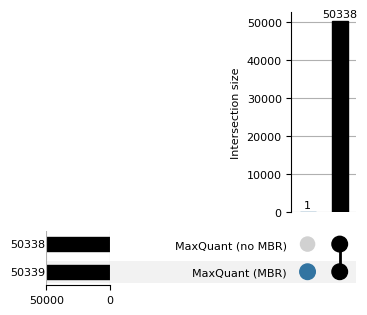

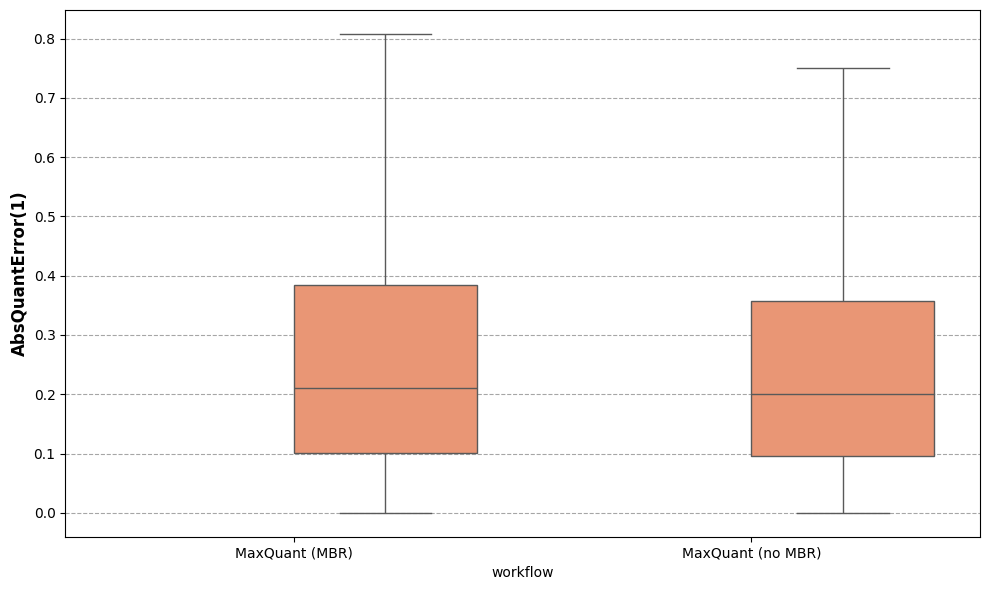

number of precursor ions before filtering:
47765
MaxQuant (MBR)
MaxQuant (no MBR)


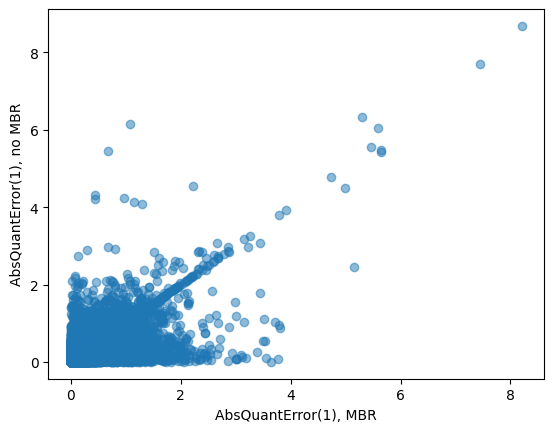

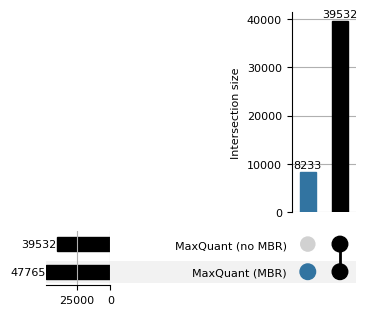

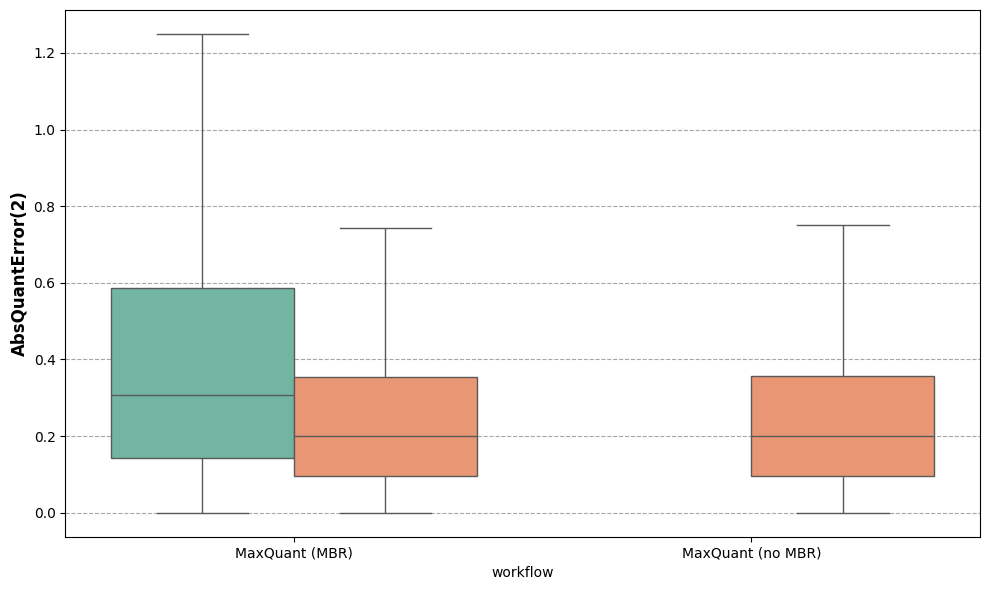

number of precursor ions before filtering:
43766
MaxQuant (MBR)
MaxQuant (no MBR)


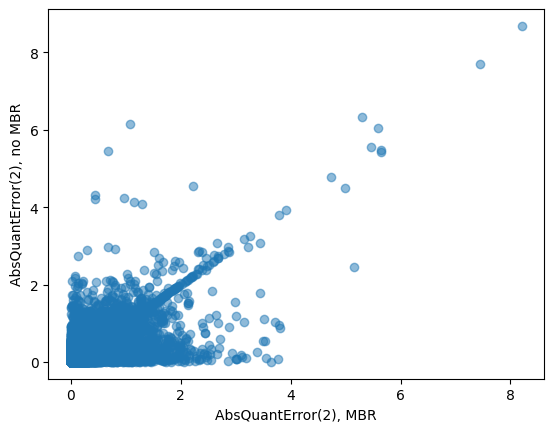

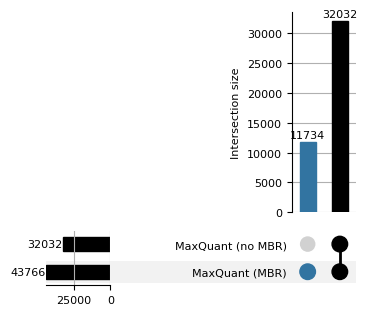

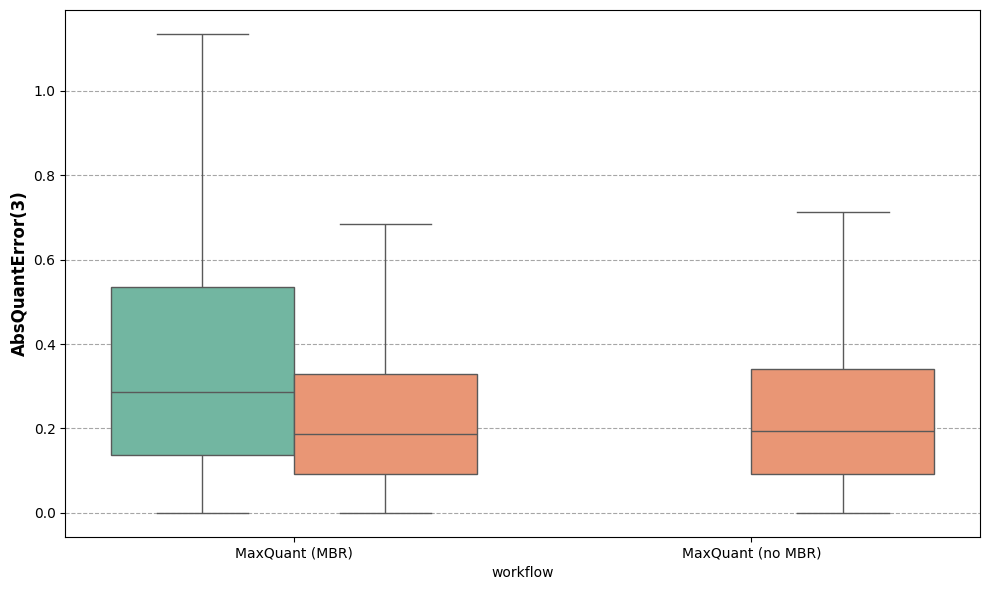

number of precursor ions before filtering:
38544
MaxQuant (MBR)
MaxQuant (no MBR)


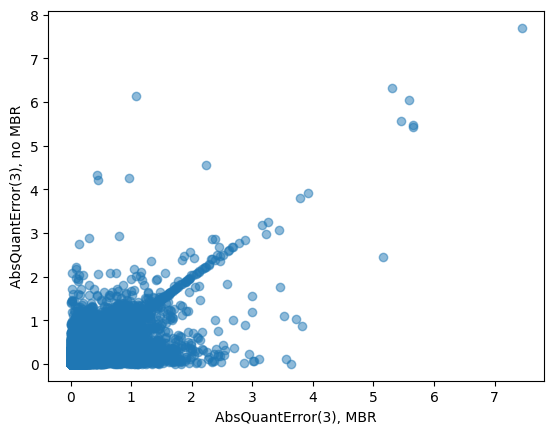

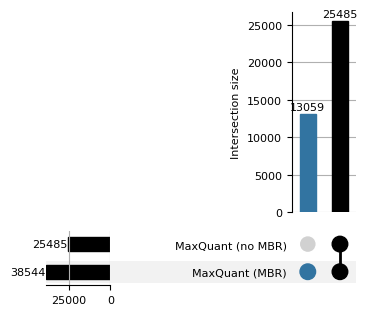

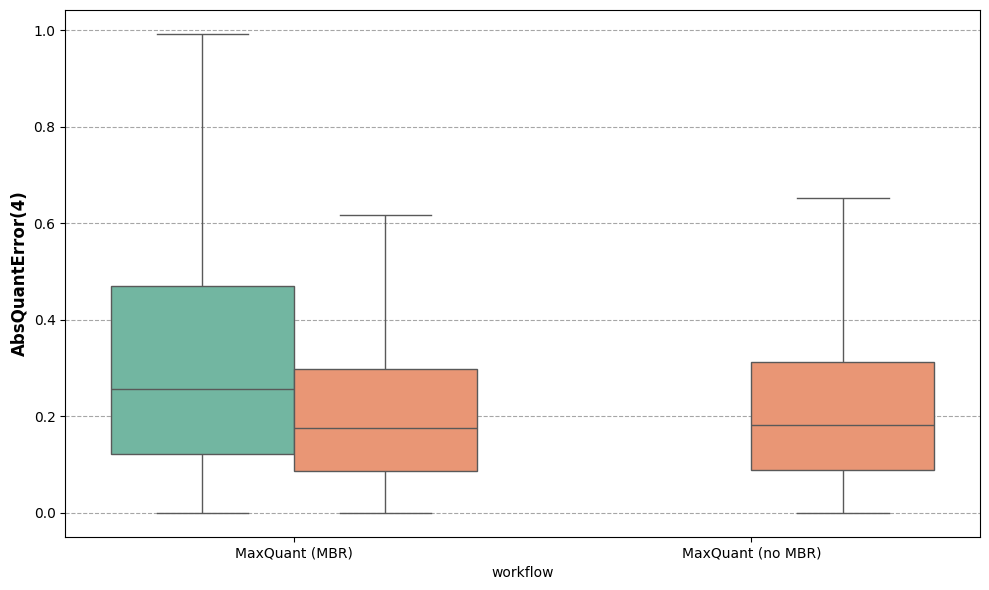

number of precursor ions before filtering:
32606
MaxQuant (MBR)
MaxQuant (no MBR)


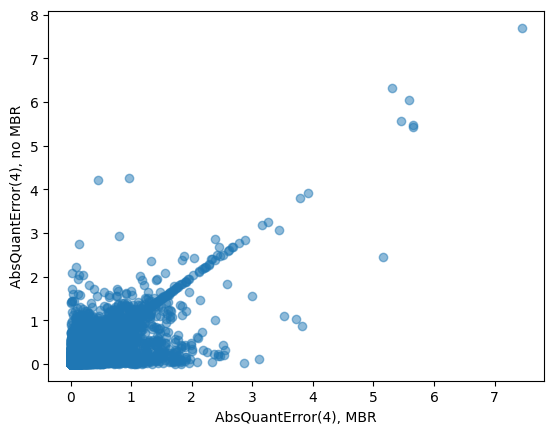

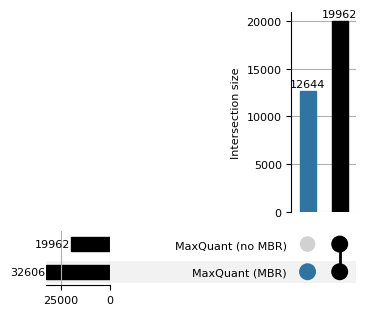

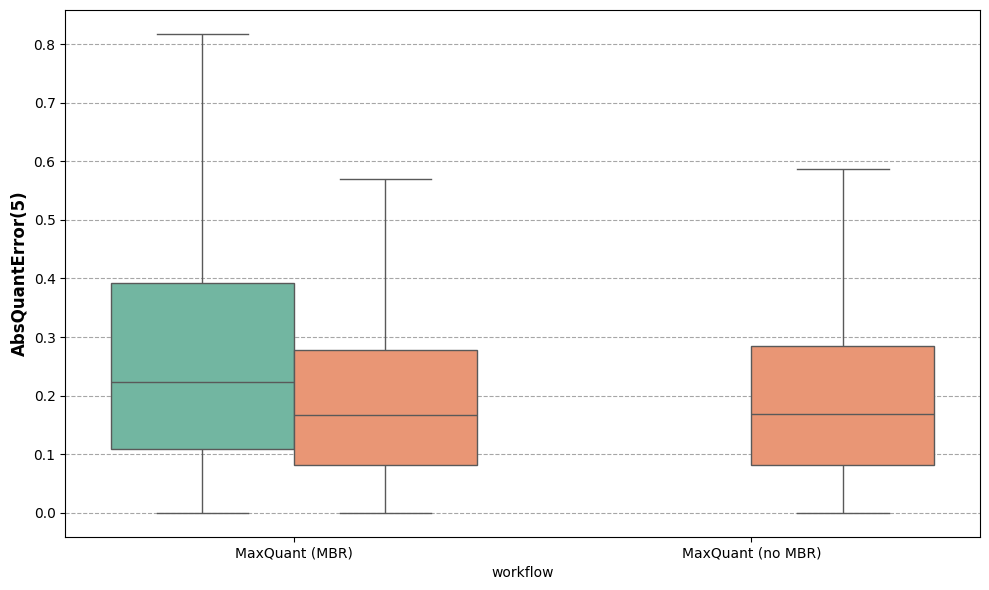

number of precursor ions before filtering:
25172
MaxQuant (MBR)
MaxQuant (no MBR)


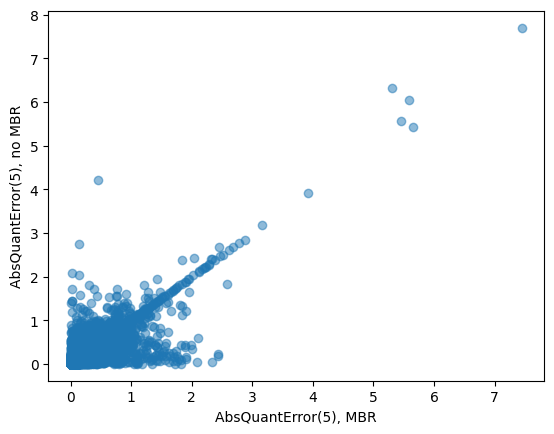

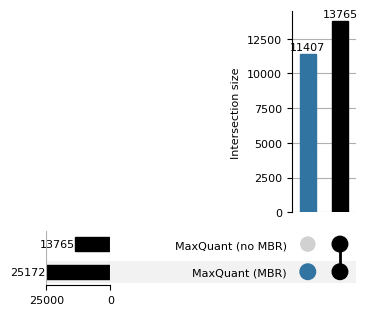

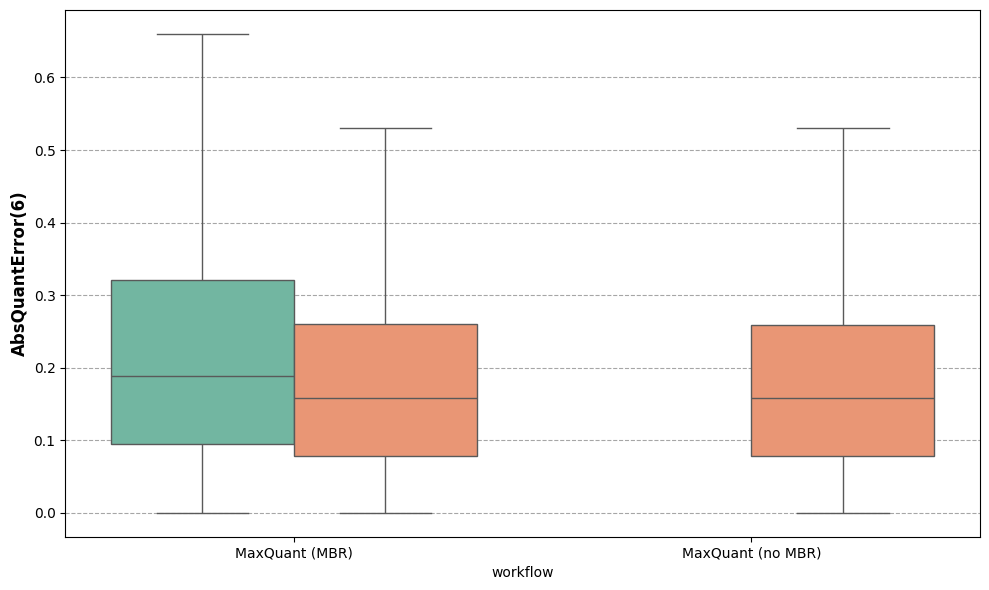

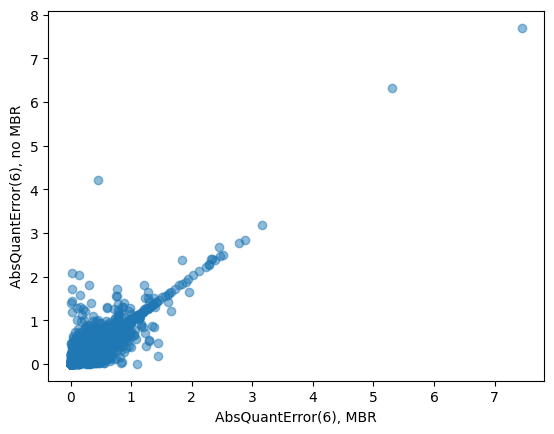

In [46]:
# suppl. fig 7

subset_hashes_MBR_MaxQuant = [
    "36b7b01b380f641722b3b34633bb53d72348eb80", # MaxQuant no MBR
    "8cbc0bce20eee581ad10326e02a09dbc316c30e1", # MaxQuant MBR
]

all_tools_mapper = {
    "[True, False]": "MaxQuant (MBR)",
    "[False, True]": "MaxQuant (no MBR)",
    "[True, True]": "all",
}

performance_df_dict = prepare_performance_dict_MBR_analysis(
    results_dict, mapper=None, subset=subset_hashes_MBR_MaxQuant
)

fig = plot_upset_and_boxplot_and_scatterplot_all_filters_MBR_analysis(
    performance_df_dict, all_tools_mapper, save_path="figures_manuscript/"
)


In [21]:
subset_hashes_MaxQuantVersions = [
    "8f4fa9a7dd1f44ac4ae7a7e7fb9b9606660f4578", # 1.5.2.8
    "f4f23a743baef55ba419a1cf0e8dd67a4cb5b7ac", # 1.5.3.30
    "5dc44925b46df18a2799648b5f975a41ba8bf89f", # 1.5.8.2
    "7912158e0522a315917e20fe434966ca9a17192e", #1.6.3.3
    "a1140a31b414d7b3110ee9b9c0456cc4f1709782", # 2.1.3.0
    "36b7b01b380f641722b3b34633bb53d72348eb80", #2.1.4.0
    "00e2f863939301a2a71178652972dad895b27520" #2.5.1.0
]

In [22]:
plot = plot_performance_metrics(
    all_datapoints, subset=subset_hashes_MaxQuantVersions, min_quant=3, subset_col="intermediate_hash", autoscale=True
)
plot

# Intersection between all the search engines: How do the unique quantifications perform?

In [23]:
subset_hashes_1pertool = [
    "2a5ef6191b8098757d490acf76bb9c2af5b89a39", # MSAngel
"9d1361331b165d6cc779ccf614419eb77057f573", # PEAKS
#"d01e87b997b84c985868204b1ed26749902fd7f9", # quantms
"6ed9da37e9d4600a9a28968c9a01db2b967d33cb", # Proline Studio
# "bbd079eda4dd3d6a51b37924d83db50022530bb6", # Sage
#"4decb9e0d2d9ed9f9be6a9ad5aa066b1dcd1e616", # WOMBAT
"a3d801fcb75c46b2e76fa7078ae0a004360ebe44", # MaxQuant
"28b0c3b9853a5b60c9e47428b8a51b4898083523", # FragPipe
"90d852742aa152dc7ed813acebf7916b0c1d5b76", # i2masschroq
]

In [24]:
all_tools_mapper = {
    # FragPipe i2MassChroQ MaxQuant MSAngel ProlineStudio PEAKS
    "[True, False, False, False, False, False]": "FragPipe",
    "[False, True, False, False, False, False]": "i2MassChroQ",
    "[False, False, True, False, False, False]": "MaxQuant",
    "[False, False, False, True, False, False]": "MSAngel",
    "[False, False, False, False, True, False]": "ProlineStudio",
    "[False, False, False, False, False, True]": "PEAKS",
    "[True, True, True, True, True, False]": "all but PEAKS",
    "[True, True, True, True, False, True]": "all but ProlineStudio",
    "[True, True, True, False, True, True]": "all but MSAngel",
    "[True, True, False, True, True, True]": "all but MaxQuant",
    "[True, False, True, True, True, True]": "all but i2MassChroQ",
    "[False, True, True, True, True, True]": "all but FragPipe",
    "[True, True, True, True, True, True]": "all",

}

In [25]:
performance_df_dict = prepare_performance_dict(
    results_dict, mapper=None, subset=subset_hashes_1pertool
)

Processing FragPipe
Tool has the following runs: dict_keys(['28b0c3b9853a5b60c9e47428b8a51b4898083523'])
Processing 28b0c3b9853a5b60c9e47428b8a51b4898083523
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys(['90d852742aa152dc7ed813acebf7916b0c1d5b76'])
Processing 90d852742aa152dc7ed813acebf7916b0c1d5b76
Processing MaxQuant
Tool has the following runs: dict_keys(['a3d801fcb75c46b2e76fa7078ae0a004360ebe44'])
Processing a3d801fcb75c46b2e76fa7078ae0a004360ebe44
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys(['2a5ef6191b8098757d490acf76bb9c2af5b89a39'])
Processing 2a5ef6191b8098757d490acf76bb9c2af5b89a39
Processing ProlineStudio
Tool has the following runs: dict_keys(['6ed9da37e9d4600a9a28968c9a01db2b967d33cb'])
Processing 6ed9da37e9d4600a9a28968c9a01db2b967d33cb
Processing quantms
Tool 

In [26]:
performance_df_dict.keys()

dict_keys(['FragPipe', 'i2MassChroQ', 'MaxQuant', 'MSAngel', 'ProlineStudio', 'PEAKS'])

number of precursor ions before filtering:
95166
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


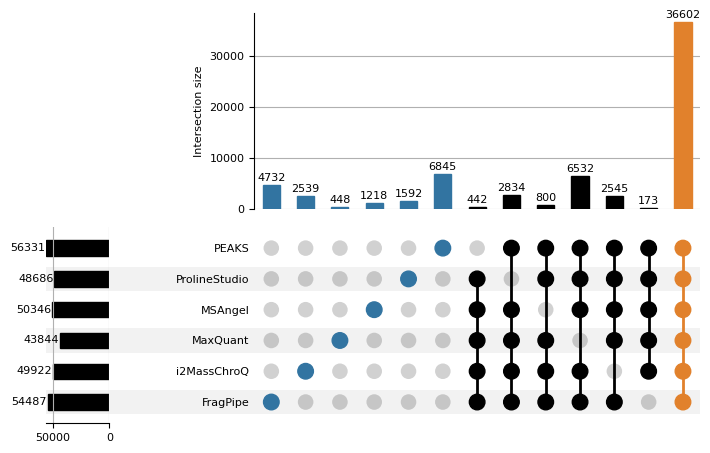

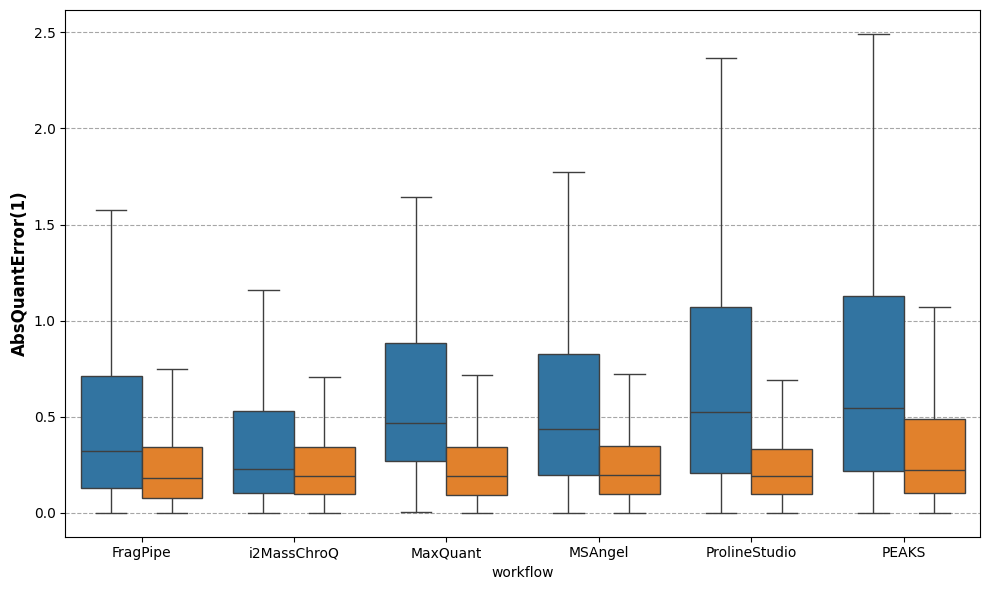

number of precursor ions before filtering:
90817
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


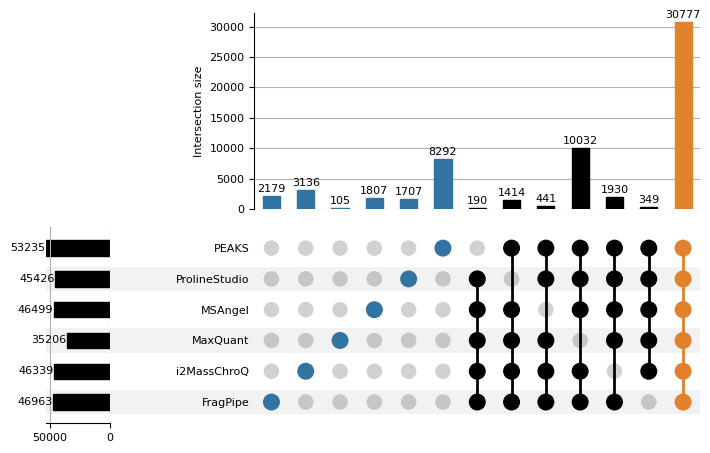

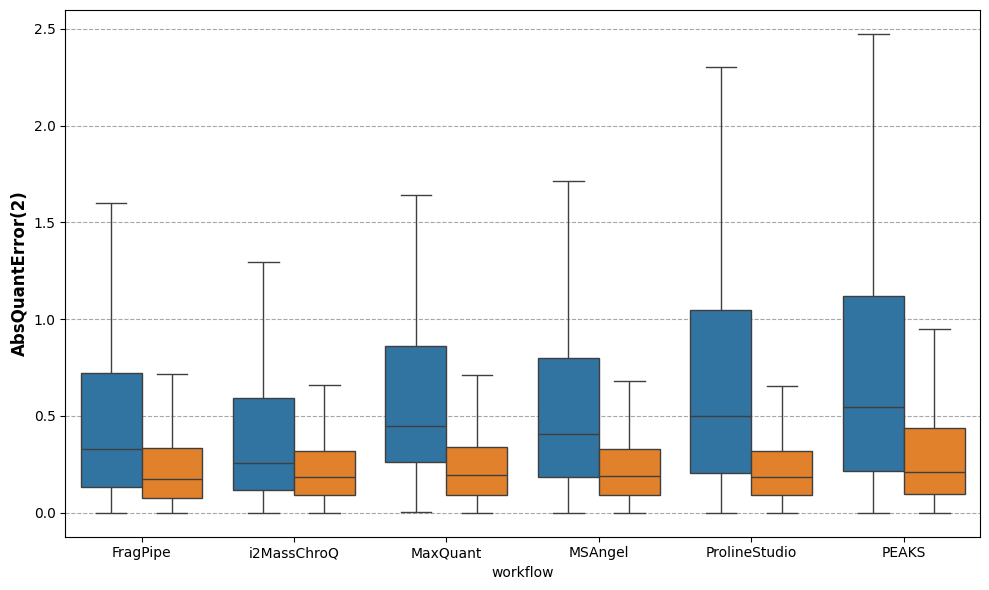

number of precursor ions before filtering:
87338
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


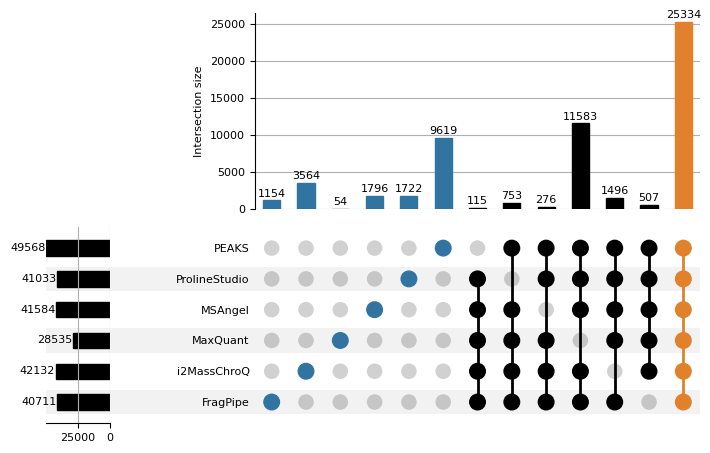

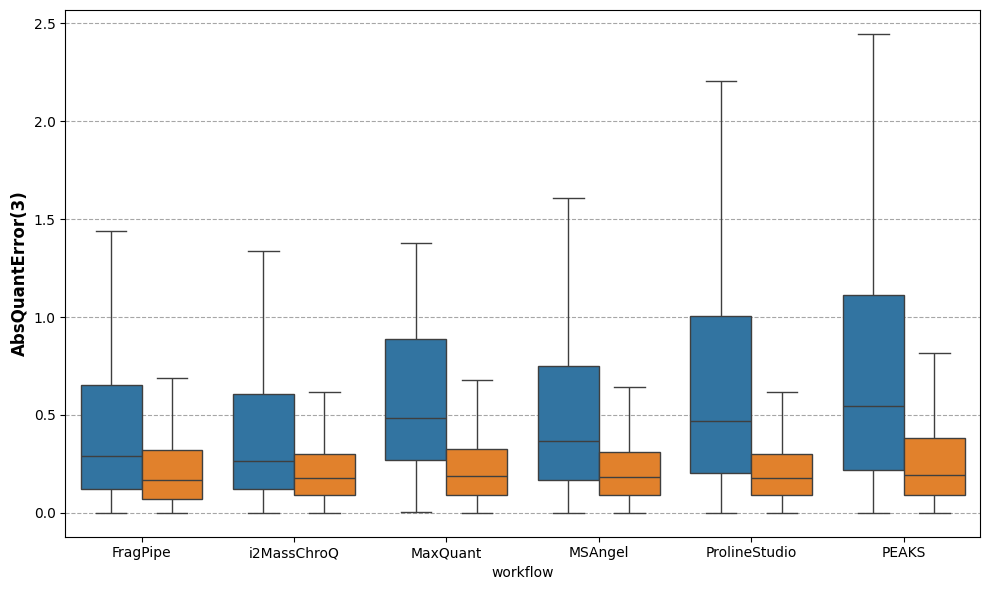

number of precursor ions before filtering:
83363
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


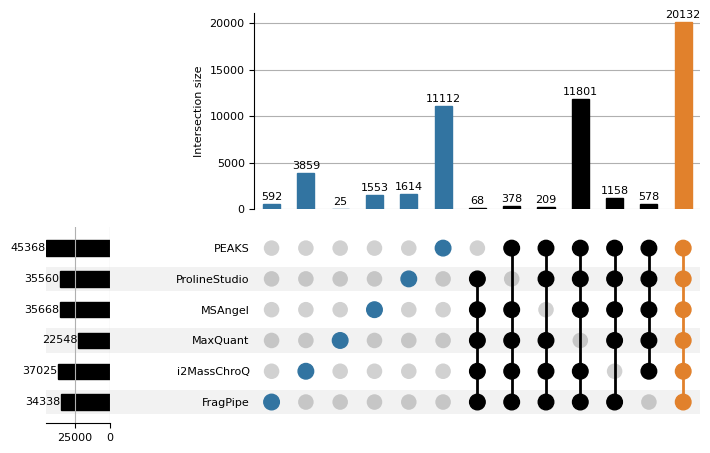

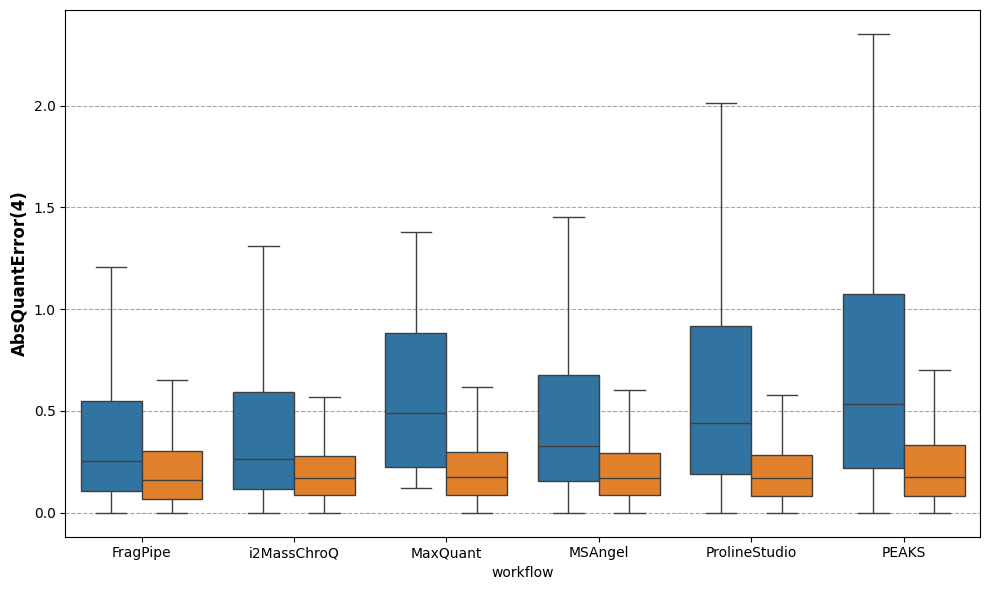

number of precursor ions before filtering:
78775
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


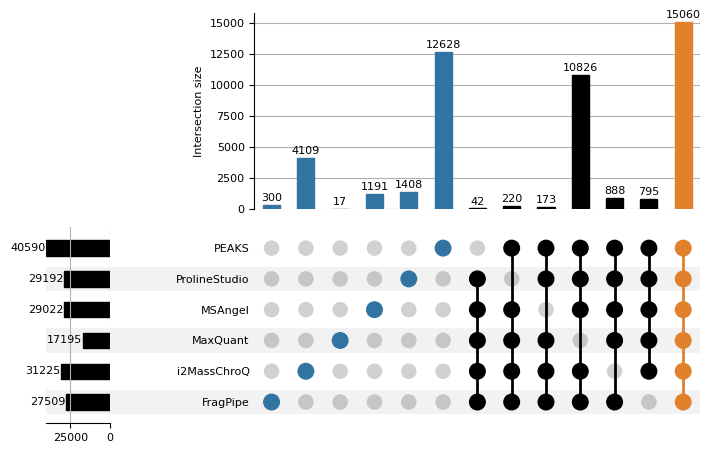

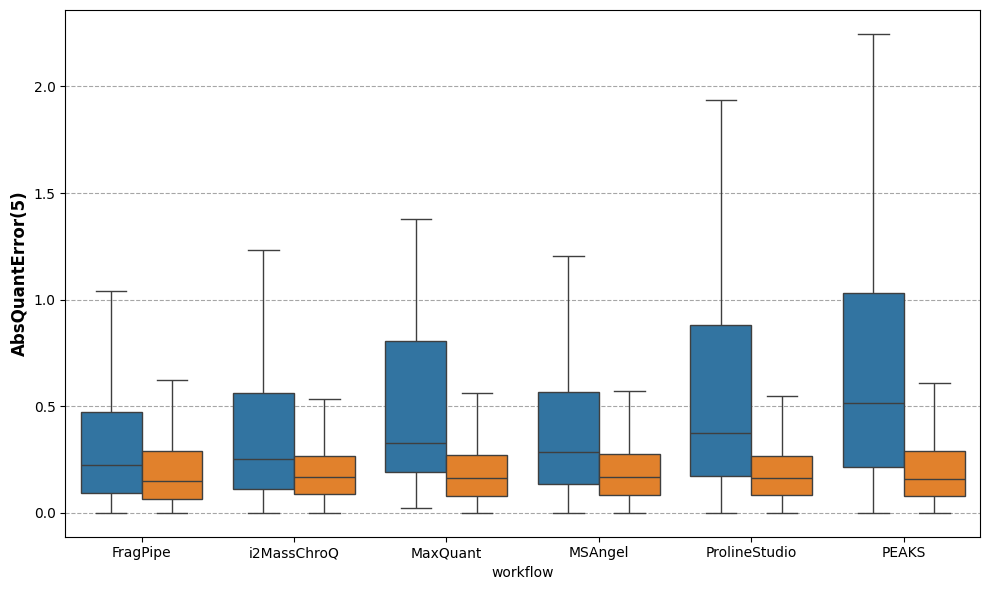

number of precursor ions before filtering:
72836
FragPipe
i2MassChroQ
MaxQuant
MSAngel
ProlineStudio
PEAKS


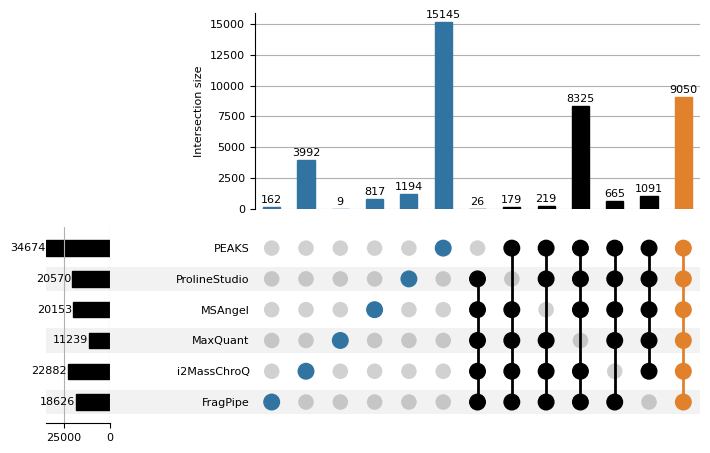

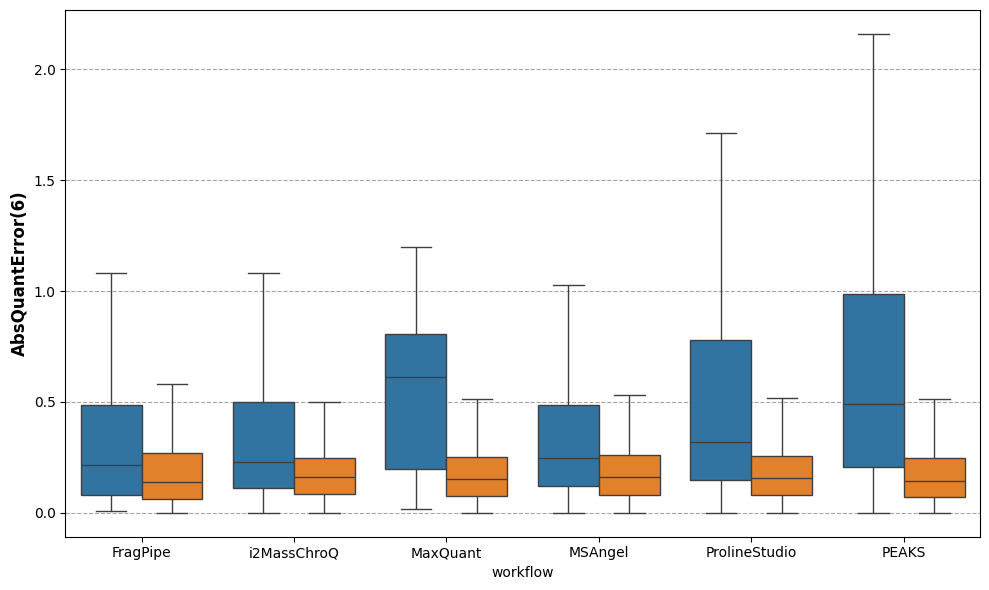

In [27]:
fig = plot_upset_and_boxplot_all_filters(
    performance_df_dict, all_tools_mapper, save_path="figures_manuscript/"
)

# A look at precursor quantification for e.coli and yeast precursors

In [54]:
def plot_pair_quantifications(
    results,
    subset,
):
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    lprec = {}
    for tool, subdict in results.items():
        for hashe, df in subdict.items():
            precursors = df["precursor ion"].unique()
            lprec[hashe] = precursors

    # prepare the data for the pair plot
    lplot = []
    for i, (tool, subdict) in enumerate(results.items()):
        for hashe, df in subdict.items():
            res = df[["precursor ion", "log2_A_vs_B", "species"]].copy()
            res["tool"] = tool
            lplot.append(res)

    gtab = pd.concat(lplot, ignore_index=True)
    gtab_wide = gtab.pivot_table(
        index=["species", "precursor ion"], columns="tool", values="log2_A_vs_B"
    )

    # Get limits for the plots
    lims = np.max(
        np.abs(gtab[gtab["species"].isin(["ECOLI", "YEAST"])]["log2_A_vs_B"].dropna())
    )
    lims = (-lims, lims)

    # Create the pair plot for E. coli
    ecoli = gtab_wide[
        gtab_wide.index.get_level_values("species") == "ECOLI"
    ].reset_index()
    g = sns.pairplot(
        ecoli.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1}
    )

    # Apply same axis limits to all subplots in E. coli pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=-2, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=-2, linestyle="--", linewidth=0.5)

    plt.suptitle("E. coli Pairplot")
    plt.tight_layout()
    plt.show()

    # Plot for yeast
    yeast = gtab_wide[
        gtab_wide.index.get_level_values("species") == "YEAST"
    ].reset_index()
    g = sns.pairplot(
        yeast.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1}
    )

    # Apply same axis limits to all subplots in Yeast pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=1, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=1, linestyle="--", linewidth=0.5)

    plt.suptitle("Yeast Pairplot")
    plt.tight_layout()
    # save svg
    plt.savefig("figures_manuscript/pair_quantifications.svg")
    plt.show()


def plot_pair_quantifications_combined(results, subset=None):
    """
    Create a combined pair plot comparing log2(A vs B) fold-changes across multiple tools
    using E. coli (lower triangle) and Yeast (upper triangle) precursor ions.

    Parameters:
        results (dict): Dictionary mapping tool name -> dict of {hash -> DataFrame} with
                        columns ['precursor ion', 'log2_A_vs_B', 'species'].
        subset (list, optional): List of tool names to include in the plot.
    """
    #print(results)
    # Filter hashes
    if subset:
        results = {
            k: {sk: v for sk, v in inner_dict.items() if sk in subset}
            for k, inner_dict in results.items()
        }

    tools = ["FragPipe", "i2MassChroQ", "MaxQuant", "MSAngel", "ProlineStudio", "PEAKS"]

    print(results.keys)

    # Aggregate DataFrames per tool
    tool_data = {}
    for tool in tools:
        dfs = [df.copy() for df in results[tool].values()]
        if len(dfs) > 0:
            tool_data[tool] = pd.concat(dfs, ignore_index=True)

    # Extract species-specific data for each tool, indexed by precursor ion
    e_coli_vals = {}
    yeast_vals = {}
    for tool, df in tool_data.items():
        ecoli_df = df[df["species"].str.upper() == "ECOLI"]
        yeast_df = df[df["species"].str.upper() == "YEAST"]
        e_coli_vals[tool] = ecoli_df.set_index("precursor ion")["log2_A_vs_B"]
        yeast_vals[tool] = yeast_df.set_index("precursor ion")["log2_A_vs_B"]

    # Determine global log2 limits
    all_vals = pd.concat(
        [s.dropna() for d in [e_coli_vals, yeast_vals] for s in d.values()]
    )
    lim = (
        np.ceil(np.percentile(np.abs(all_vals), 99.5)) * 1.1
        if not all_vals.empty
        else 1.0
    )

    # Colors
    col_ecoli = "#1f77b4"
    col_yeast = "#ff7f0e"

    n = len(tools)
    fig, axes = plt.subplots(n, n, figsize=(3 * n, 3 * n))

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            tool_i = tools[i]
            tool_j = tools[j]

            if i == j:
                ec_vals = e_coli_vals[tool_i].dropna()
                yt_vals = yeast_vals[tool_i].dropna()
                if not ec_vals.empty:
                    sns.kdeplot(ec_vals, ax=ax, color=col_ecoli, fill=True, alpha=0.4)
                if not yt_vals.empty:
                    sns.kdeplot(yt_vals, ax=ax, color=col_yeast, fill=True, alpha=0.4)
                ax.axvline(-2, linestyle="--", color=col_ecoli, lw=1)
                ax.axvline(1, linestyle="--", color=col_yeast, lw=1)
                ax.set_xlim(-lim, lim)
                if not i == 0:
                    ax.yaxis.set_visible(False)
                if not j == n - 1:
                    ax.xaxis.set_visible(False)

            elif i > j:  # E. coli: lower triangle
                ax.set_facecolor(to_rgba(col_ecoli, alpha=0.1))
                x = e_coli_vals[tool_j]
                y = e_coli_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(
                    x.loc[common], y.loc[common], color=col_ecoli, alpha=0.3, s=10, rasterized=True
                )
                ax.axhline(-2, linestyle="--", color="gray", lw=0.8)
                ax.axvline(-2, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            else:  # Yeast: upper triangle
                ax.set_facecolor(to_rgba(col_yeast, alpha=0.1))
                x = yeast_vals[tool_j]
                y = yeast_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(
                    x.loc[common], y.loc[common], color=col_yeast, alpha=0.3, s=10, rasterized=True
                )
                ax.axhline(1, linestyle="--", color="gray", lw=0.8)
                ax.axvline(1, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            # Clean ticks
            if i < n - 1:
                ax.set_xticks([])
            else:
                ax.set_xlabel(tool_j)
            if j > 0:
                ax.set_yticks([])
            else:
                ax.set_ylabel(tool_i)

    # Final layout and legend
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color=col_ecoli, lw=4, label="E. coli"),
            plt.Line2D([0], [0], color=col_yeast, lw=4, label="Yeast"),
        ],
        loc="upper right",
        bbox_to_anchor=(1.09, 0.99),
        title="Species",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # save as svg
    plt.savefig("figures_manuscript/pair_quantifications_combined.svg")

    plt.show()

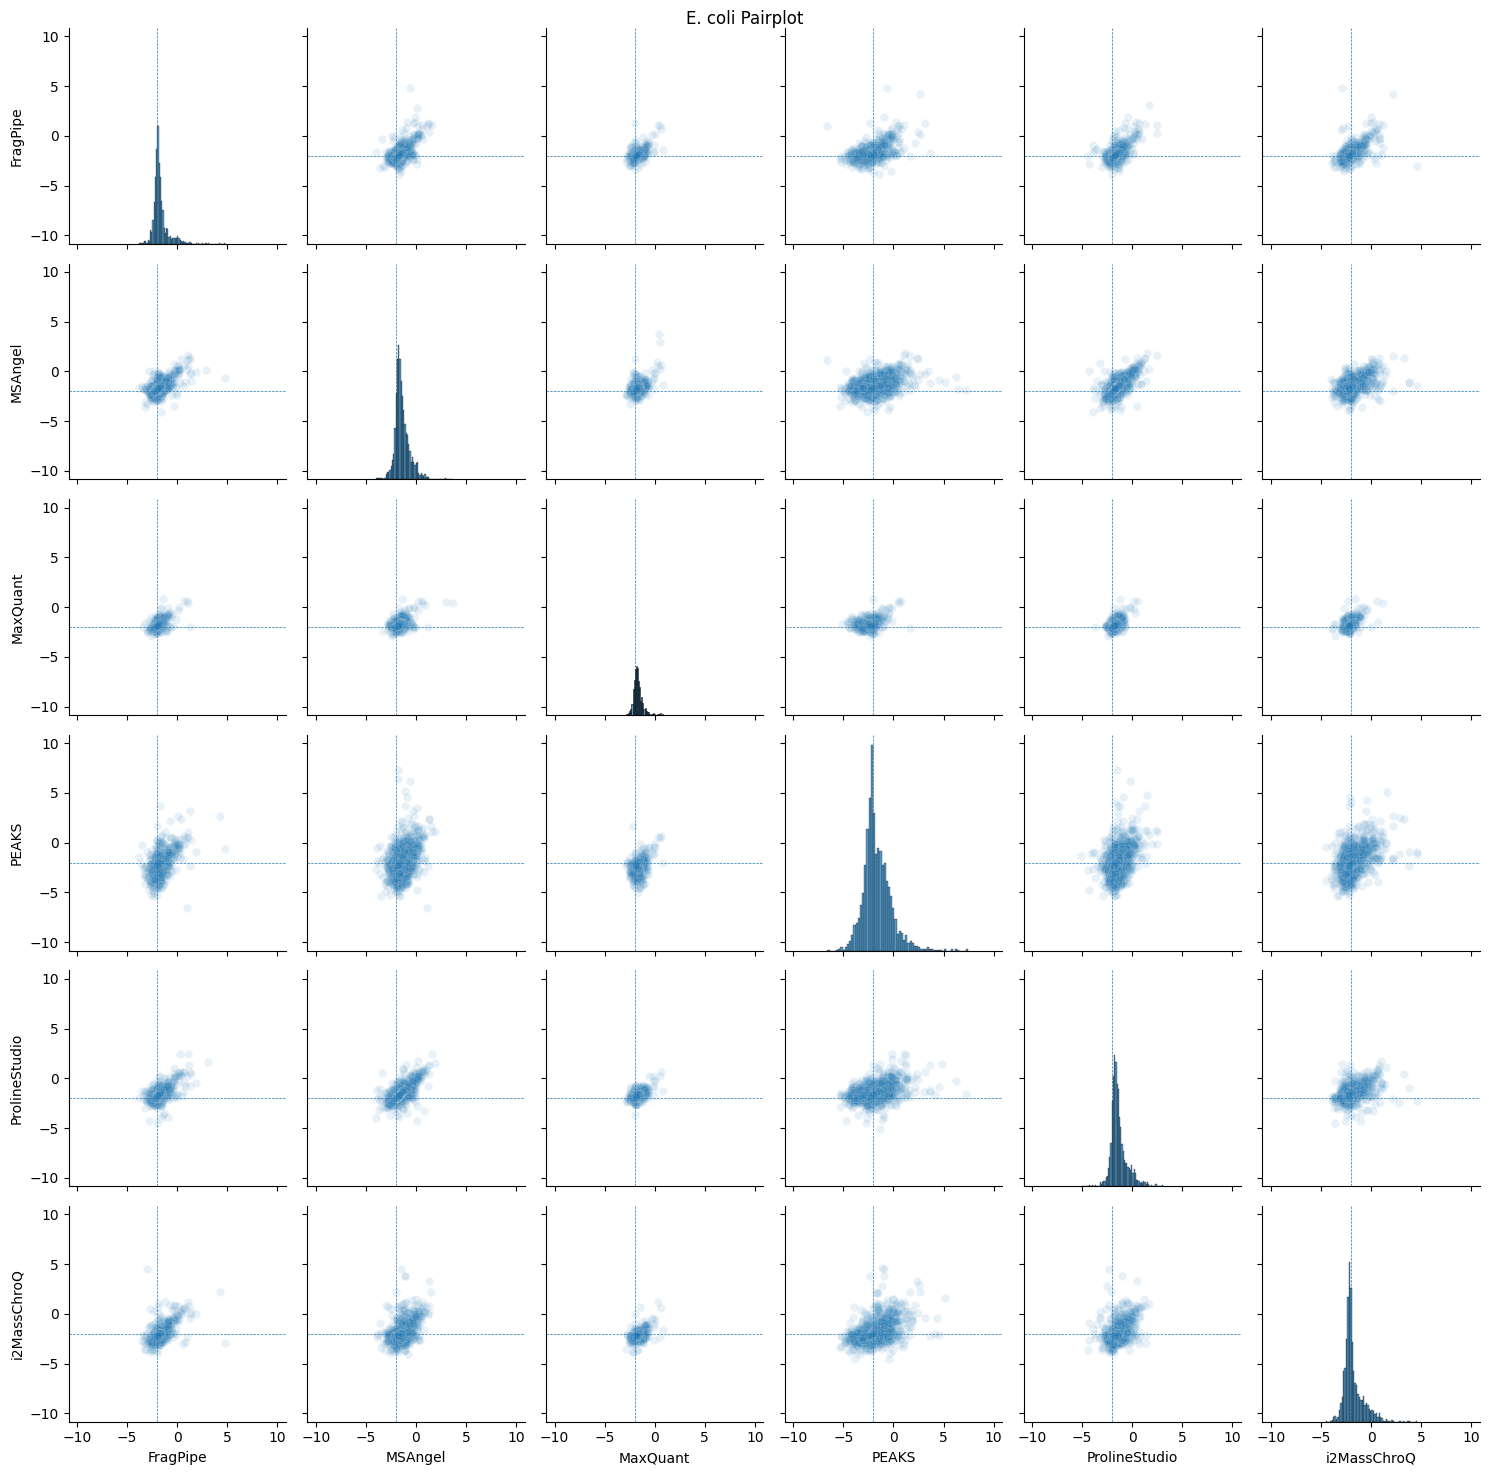

KeyboardInterrupt: 

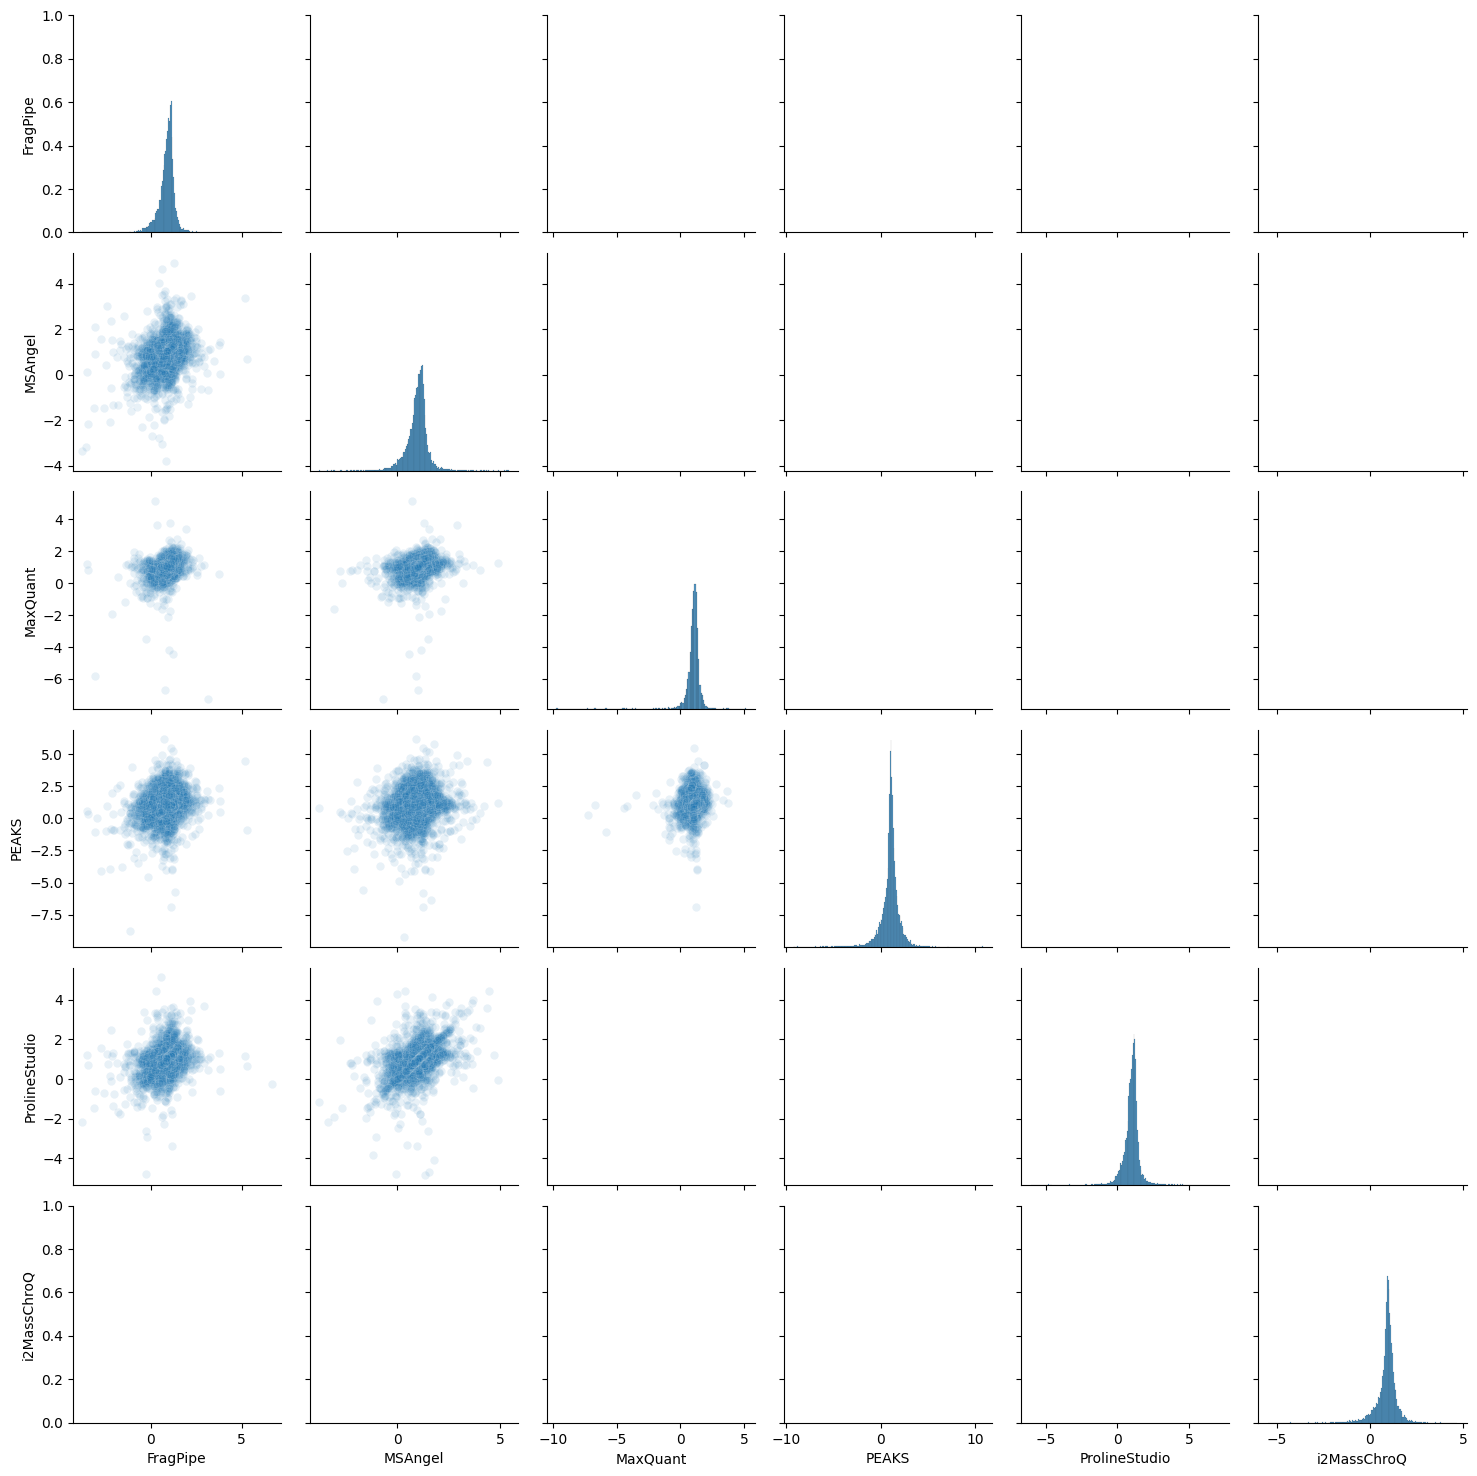

In [32]:
results = plot_pair_quantifications(results_dict, subset=subset_hashes_1pertool)

<built-in method keys of dict object at 0x7f1f00b48b00>


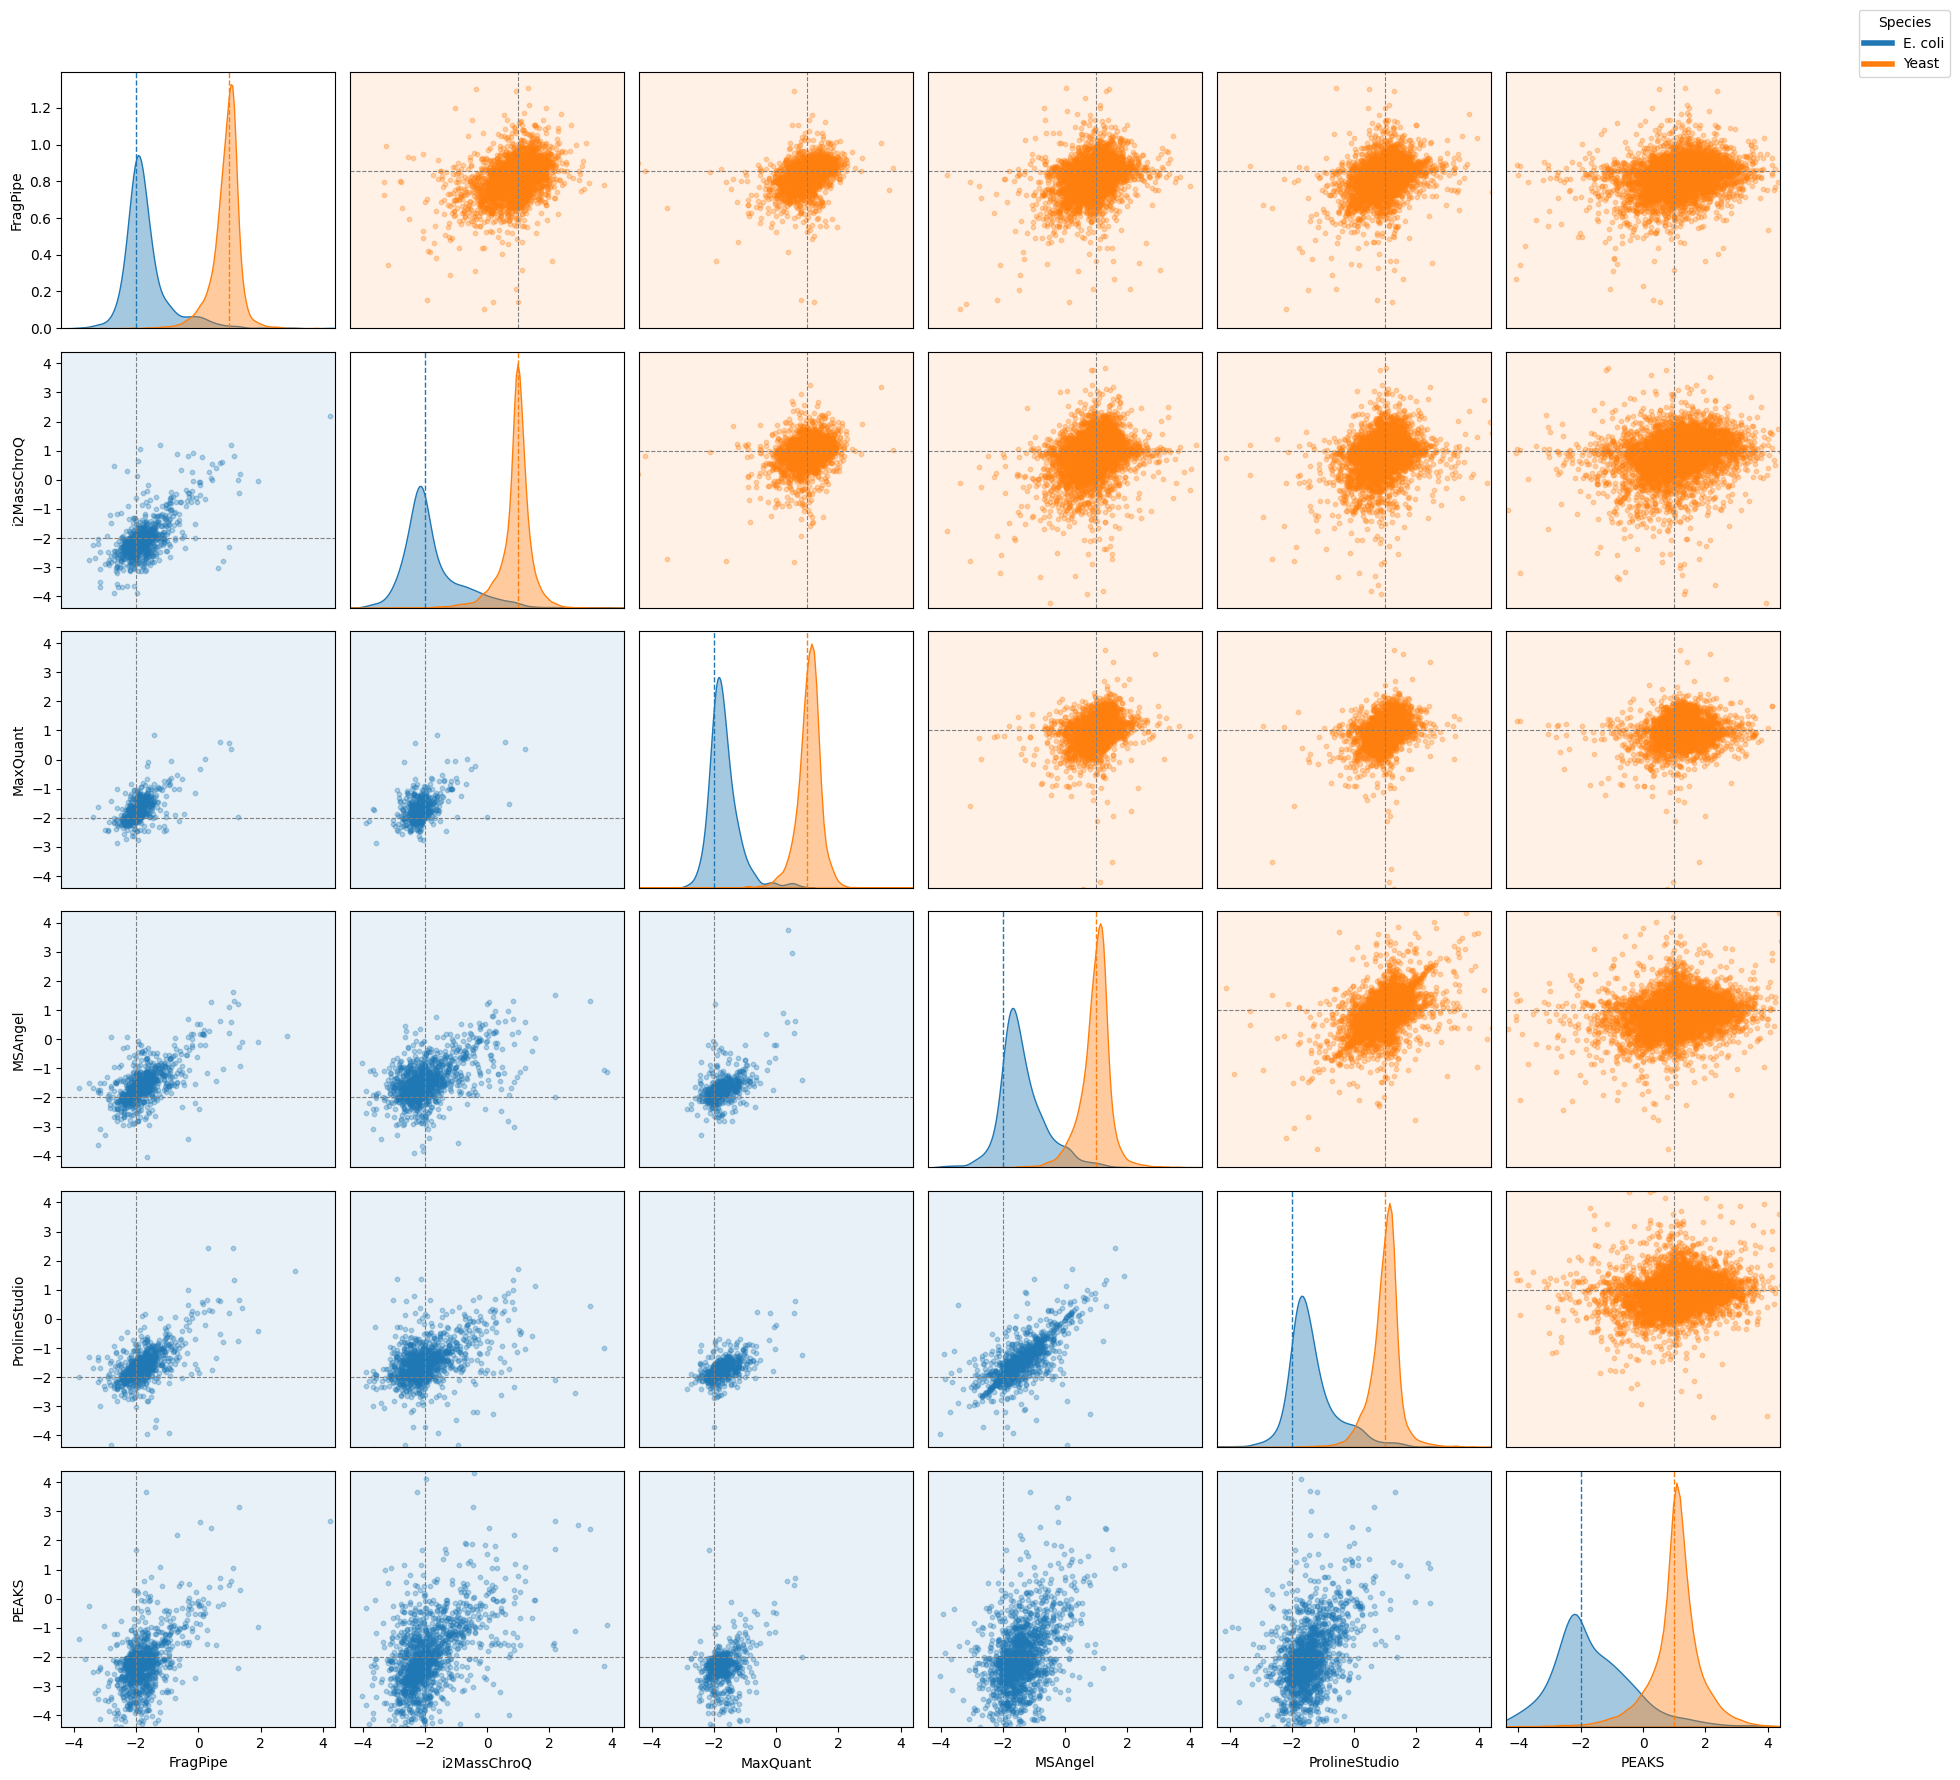

In [55]:
plot_pair_quantifications_combined(results_dict, subset=subset_hashes_1pertool)

# Quantified in more runs -> higher intensity?

Processing FragPipe
Tool has the following runs: dict_keys([])
Processing WOMBAT
Tool has the following runs: dict_keys([])
Processing i2MassChroQ
Tool has the following runs: dict_keys([])
Processing MaxQuant
Tool has the following runs: dict_keys(['a3d801fcb75c46b2e76fa7078ae0a004360ebe44'])
Processing a3d801fcb75c46b2e76fa7078ae0a004360ebe44
Processing Sage
Tool has the following runs: dict_keys([])
Processing AlphaPept
Tool has the following runs: dict_keys([])
Processing MSAngel
Tool has the following runs: dict_keys([])
Processing ProlineStudio
Tool has the following runs: dict_keys([])
Processing quantms
Tool has the following runs: dict_keys([])
Processing PEAKS
Tool has the following runs: dict_keys([])


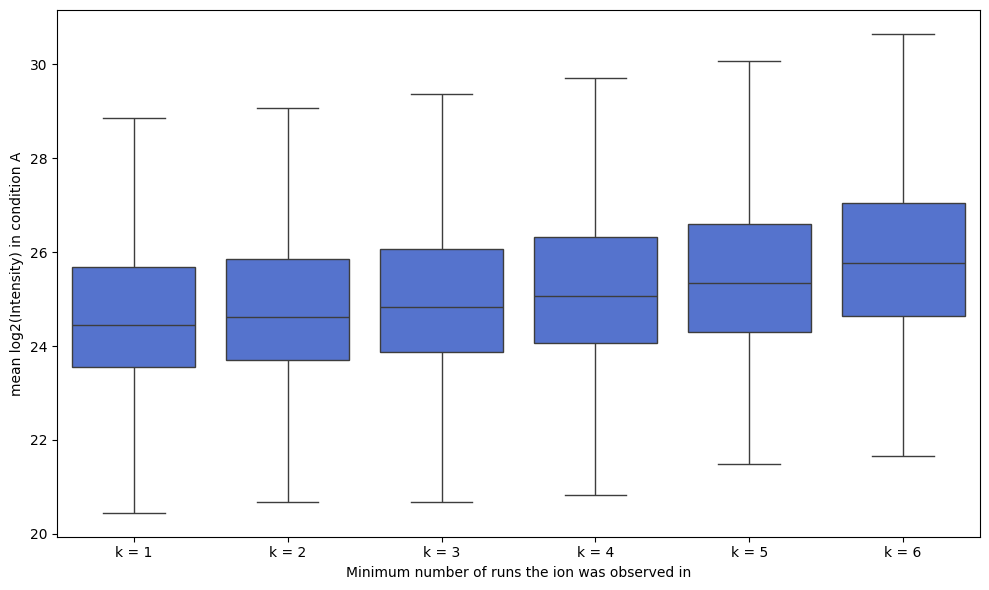

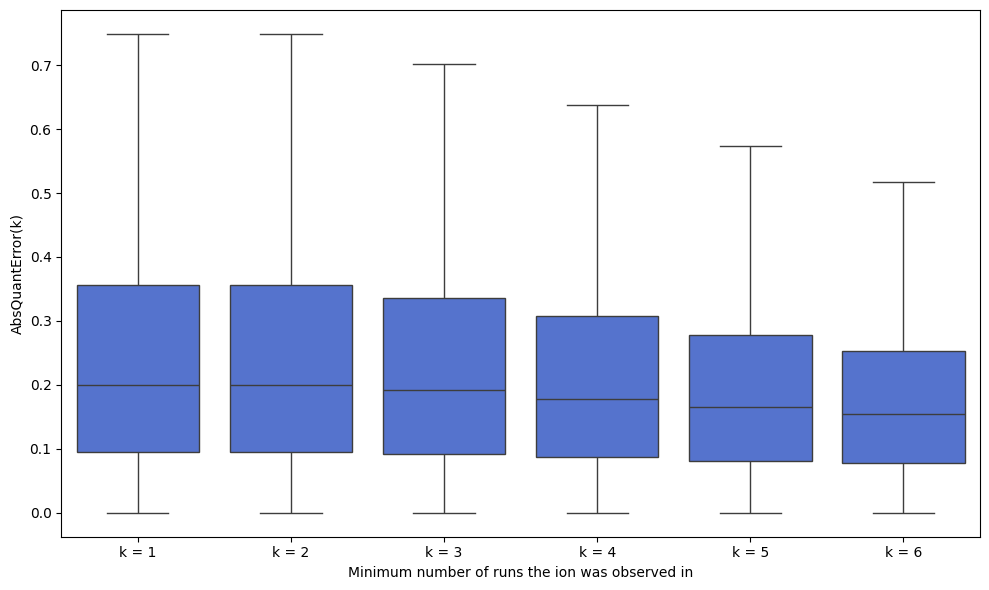

In [53]:
subset_hashes_example = [
"a3d801fcb75c46b2e76fa7078ae0a004360ebe44", # MaxQuant
]

performance_df_dict = prepare_performance_dict(
    results_dict, mapper=None, subset=subset_hashes_example
)

fig = plot_filtered_intensity_boxplots(
    performance_df_dict
)